Audio Classifier
=========================

## Important information

* Choose a group name/number and rename the file with it.
* Be sure to enter the names of every member in the group in the cell below.
* Use the power of number and work together as a team.
* You can employ the use of the HPC (high perfomance computer) provided your server account has been established.
* The tutor is always available to give more explanation and assistance whenever/wherever required, but make sure you have made effort yourself.
* Please remove all test codes.
* The solutions to the tasks should be turn in on Friday 13th Dec, end of the day (12am). 
* A notebook submission is required per group, no multiple submissions from same group. Submit by attaching only the .ipynb file please, not zip and I don't need other files (e.g the data) I already have them.

This task is inspired by the Audio Classifier Tutorial (found [here](https://pytorch.org/tutorials/beginner/audio_classifier_tutorial.html?highlight=audio))
**Author**: `Winston Herring <https://github.com/winston6>`_

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset. First, let’s
import the common torch packages as well as ``torch``, ``torchaudio``, ``pandas``,
and ``numpy``. ``torchaudio`` is available `here <https://github.com/pytorch/audio>`_
and can be installed by following the
instructions on the website but I encountered a lot of trouble installing it, this ` conda install -c pytorch torchaudio-cpu ` rather worked for me.

If you have a CUDA GPU use that. Running
the network on a GPU will greatly decrease the training/testing runtime.




1: Importing the Dataset
---------------------

We will use the UrbanSound8K dataset to train our network. It is
available for free `here <https://urbansounddataset.weebly.com/>`_ and contains
10 audio classes with over 8000 audio samples! Once you have downloaded
the compressed dataset, extract it to your current working directory.
First, we will look at the csv file that provides information about the
individual sound files. ``pandas`` allows us to open the csv file and
use ``.iloc()`` to access the data within it.




The 10 audio classes in the UrbanSound8K dataset are air_conditioner,
car_horn, children_playing, dog_bark, drilling, enginge_idling,
gun_shot, jackhammer, siren, and street_music. Let’s play a couple files
and see what they sound like. The first file is street music and the
second is an air conditioner.




2: Formatting the Data
-------------------

Now that we know the format of the csv file entries, we can construct
our dataset. We will create a rapper class for our dataset using
``torch.utils.data.Dataset`` that will handle loading the files and
performing some formatting steps. The UrbanSound8K dataset is separated
into 10 folders. We will use the data from 9 of these folders to train
our network and then use the 10th folder to test the network. The rapper
class will store the file names, labels, and folder numbers of the audio
files in the inputted folder list when initialized. The actual loading
and formatting steps will happen in the access function ``__getitem__``.

In ``__getitem__``, we use ``torchaudio.load()`` to convert the wav
files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for UrbanSound8K). The dataset uses two channels for audio so
we will use ``torchaudio.transforms.DownmixMono()`` (not available in the latest version of `torchaudio`) to convert the audio
data to one channel. Next, we need to format the audio data. The network
we will make takes an input size of 32,000, while most of the audio
files have well over 100,000 samples. The UrbanSound8K audio is sampled
at 44.1kHz, so 32,000 samples only covers around 700 milliseconds. By
downsampling the audio to aproximately 8kHz, we can represent 4 seconds
with the 32,000 samples. This downsampling is achieved by taking every
fifth sample of the original audio tensor. Not every audio tensor is
long enough to handle the downsampling so these tensors will need to be
padded with zeros. The minimum length that won’t require padding is
160,000 samples.




3: Define the Network
------------------

For this task we want to closely reproduce the achitectures described in https://arxiv.org/pdf/1610.00087.pdf. You task is to read extensively the paper and reproduce the achitectures <font color='green'> M3, M5, M11 and M18. The M34-res is a bonus.</font>
While attempting to reproduce the architectures endeavour to read through the common [pitfalls](https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV) to get it right.

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




4: Training and Testing the Network
--------------------------------

You can define a training function that will feed our training data into the model and perform the backward pass and optimization steps. You can also make one for testing the networks accuracy and set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.




Finally, we can train and test the network. Train the network for as many epochs as time allows you. The network will be tested after each epoch to see how the accuracy varies during the training.

Conclusion
----------

If trained on 9 folders, the network should be about 40% accurate by the end of the training process for the least possible epochs. Training on less folders will result in a lower overall accuracy. Greater accuracies can be achieved using deeper CNNs at the expense of a larger memory footprint.

For more advanced audio applications, such as speech recognition,
recurrent neural networks (RNNs) are commonly used. There are also other
data preprocessing methods, such as finding the mel frequency cepstral
coefficients (MFCC), that can reduce the size of the dataset.




<font color='red'>GOOD NEWS</font> : Solutions to the first two section have been given to you freely. <font color='blue'>You are welcome</font>. 

In [0]:
!pip3 install torchaudio

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class AudioDataset(Dataset):
   

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        csvData = pd.read_csv(file_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folds:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.audio_paths = audio_paths
        #self.mixer = torchaudio.transforms.DownmixMono() #UrbanSound8K uses two channels, this will convert them to one
        self.folds = folds
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths + "/" + "fold" + str(self.folders[idx]) + "/" + self.file_names[idx]
        #audio_path = self.audio_paths[index]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        #labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_new, self.labels[idx]
      
    def __len__(self):
        return len(self.file_names)

    


In [0]:
class M3(nn.Module):
    def __init__(self):
        super(M3, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, 80, 4, padding=38)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(256, 256, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(256, 10, 3, padding=1)
        self.avgPool = nn.AvgPool1d(500) #input should be 512x30 so this outputs a 512x1

        
    def forward(self, x):
        x = self.conv1(x)
        
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        
        x = self.avgPool(x)
        x = x.view(-1, 10)
        
        return x



In [0]:
class M5(nn.Module):
    def __init__(self):
        super(M5, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4, padding=38)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(512, 10, 3, padding=1)
        self.avgPool = nn.AvgPool1d(31)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.avgPool(x)
        x = x.view(-1, 10)
        return x


In [0]:
def m_block(input_channels, output_channels, num_layers):
  
  first_layer =  [
          nn.Conv1d(input_channels, output_channels, 3, padding=1),
          nn.BatchNorm1d(output_channels),
          nn.ReLU(),
        ] 
  other_layers = [
          nn.Conv1d(output_channels, output_channels, 3, padding=1),
          nn.BatchNorm1d(output_channels),
          nn.ReLU(),
       ] * (num_layers-1) 
  max_pool_layer = [ nn.MaxPool1d(4)]

  all_layers = first_layer + other_layers + max_pool_layer

  block = nn.Sequential(*all_layers)
  return block
class M11(nn.Module):
    def __init__(self):
        super(M11, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4,padding=38)
         
        self.bn1 = nn.BatchNorm1d(64)

        self.pool1 = nn.MaxPool1d(4)

        self.block_1 = m_block(64, 64, 2)


        self.block_2 = m_block(64, 128, 2)


        self.block_3 = m_block(128, 256, 3)



        self.block_4 = m_block(256, 512, 2)

        self.conv2 = nn.Conv1d(512, 10, 3, padding=1)
        self.avgPool = nn.AvgPool1d(7) #input should be 512x30 so this outputs a 512x1
        
        
    def forward(self, x):
       
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.conv2(x)
        x = self.avgPool(x)
        x = x.view(-1, 10)
        return x




In [0]:

class M18(nn.Module):
    def __init__(self):
        super(M18, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4,padding=38)
         
        self.bn1 = nn.BatchNorm1d(64)

        self.pool1 = nn.MaxPool1d(4)

        self.block_1 = m_block(64, 64, 4)

        self.block_2 = m_block(64, 128, 4)

        self.block_3 = m_block(128, 256, 4)

        self.block_4 = m11_block(256, 512, 4)

        self.conv2 = nn.Conv1d(512, 10, 3, padding=1)
        self.avgPool = nn.AvgPool1d(7) #input should be 512x30 so this outputs a 512x1
        
        
    def forward(self, x):
       
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.conv2(x)
        x = self.avgPool(x)
        x = x.view(-1, 10)
        return x



In [0]:
class ResUnit(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(ResUnit, self).__init__()
    self.conv1 = nn.Conv1d(input_channels, output_channels, 3, padding=1)
    self.bn1 = nn.BatchNorm1d(num_features=output_channels)
    self.conv2 = nn.Conv1d(output_channels, output_channels, 3, padding=1)
    self.bn2 = nn.BatchNorm1d(num_features=output_channels)
  def forward(self, x):
    x = self.bn1(self.conv1(x))
    x = F.relu(x)

    x = self.bn2(self.conv2(x))
    x = F.relu(x)

    return x
    


class ResBlock(nn.Module):
  def __init__(self, input_channels, output_channels, num_layers, is_pool=True):
    super(ResBlock, self).__init__()
    self.input_channels = input_channels
    self.output_channels = output_channels
    self.num_layers = num_layers
    self.pool =  nn.MaxPool1d(4)
    self.is_pool = is_pool
    
  def forward(self, x):
    for i in range(self.num_layers):
      conv = nn.Conv1d(x.shape[1], self.output_channels, 1)
      res = conv(x) 
      if i==0:
        unit = ResUnit(self.input_channels, self.output_channels)
      else:
        unit = ResUnit(self.output_channels, self.output_channels)
      x = unit(x)
      x = res + x
    if self.is_pool:
      x = self.pool(x)
    return x


    
class M34Res(nn.Module):
    def __init__(self):
        super(M34Res, self).__init__()
        self.conv1 = nn.Conv1d(1, 48, 80, 4,padding=38)
        self.bn1 = nn.BatchNorm1d(48)
        self.pool1 = nn.MaxPool1d(4)
  

        self.block_1 = ResBlock(48, 48, 3)

        self.block_2 = ResBlock(48, 96, 4)

        self.block_3 = ResBlock(96, 192, 6)

        self.block_4 = ResBlock(192, 384, 3, is_pool=False)

        self.conv2 = nn.Conv1d(384, 10, 3, padding=1)
        self.avgPool = nn.AvgPool1d(31) #input should be 512x30 so this outputs a 512x1
        
        
    def forward(self, x):
       
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.conv2(x)
        x = self.avgPool(x)
        x = x.view(-1, 10)
        return x



In [0]:
class KFoldIterable:
  def __init__(self, batch_size=64):
    self.file_path = '/content/drive/My Drive/UrbanSound8K/metadata/UrbanSound8K.csv'
    self.audio_paths = '/content/drive/My Drive/UrbanSound8K/audio'
    self.all_folders = list(range(1, 11))
    self.current_pos = 0 
    self.batch_size = batch_size
    

  def __iter__(self):
    return self
  def __next__(self): 
    if self.current_pos>=len(self.all_folders):
      raise StopIteration
    folder = self.all_folders[self.current_pos]
    self.current_pos += 1

    test_folders = [folder]
    train_folders = [f for f in self.all_folders if f!= folder]

    train_set = AudioDataset(self.file_path, self.audio_paths, train_folders)
    test_set = AudioDataset(self.file_path, self.audio_paths, test_folders)

    kwargs = {'num_workers': 8, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = self.batch_size, shuffle = True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = self.batch_size, shuffle = False, **kwargs)
    print("Current K-Fold is: {} and kwargs:{}".format(folder, kwargs))
    return train_loader, test_loader, folder

In [0]:
def plot_history(train_history, test_history, model_type, fold):
  train_losses, train_accs = train_history
  test_losses, test_accs = test_history
  plt.figure(figsize=(14, 8))
  plt.subplot(121)
  plt.title("Train and Test accuracies for model: {} and fold: {}".format(model_type, fold))
  plt.plot(train_accs, label="train_acc")
  plt.plot(test_accs, label="test_acc")
  plt.legend()
  
  plt.subplot(122)
  plt.title("Train and Test losses for model: {} and fold: {}".format(model_type, fold))
  plt.plot(train_losses, label="train_losses")
  plt.plot(test_losses, label="test_loss")
  plt.legend()
  plt.show()
  

In [0]:
def accuracy(output, target):
    return 100 * (output.argmax(1) == target).float().mean()# why 100?


#Test
def test(model, test_loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    total_acc = 0
    for data, target in test_loader:
      with torch.no_grad():
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        acc = accuracy(output, target)
        loss = criterion(output, target)
        total_loss += loss.item()
        total_acc += acc.item()
    return total_loss/len(test_loader), total_acc/len(test_loader)




def train(model, num_epochs, train_loader, test_loader, criterion, optimizer, scheduler):
  model = model.cuda()
  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []
  for epoch in range(num_epochs):
    total_loss = 0
    total_accuracy = 0
    model.train()
    
    for batch, (features, targets) in enumerate(train_loader):
      features = features.cuda()
      targets = targets.cuda()
      outputs = model(features)
      loss = criterion(outputs, targets)

      acc = accuracy(outputs, targets)
      total_accuracy += acc.item()
      total_loss+= loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss = total_loss/float(len(train_loader))
    train_losses.append(avg_loss)
    avg_acc = total_accuracy/float(len(train_loader))
    train_accuracies.append(avg_acc)
    test_loss, test_accuracy = test(model, test_loader, criterion)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Train Epoch: {} train loss: {:.4f} train accuracy:{:.2f}  test loss: {:.4f} test accuracy: {:.2f}'.format(epoch + 1, avg_loss, avg_acc, test_loss, test_accuracy))
    scheduler.step()
  return (train_losses, train_accuracies), (test_losses, test_accuracies)


In [0]:
def train_model(config):
  criterion = nn.CrossEntropyLoss()
  epochs = config["num_epochs"]
  k_fold_iter = iter(KFoldIterable())
  train_loader, test_loader, fold = config["data_loaders"]
  model = config["model"]()
  optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
  train_history, test_history = train(model, epochs, train_loader, test_loader, criterion, optimizer, scheduler)
  plot_history(train_history, test_history, config['model_name'], fold)
  del model
  del optimizer
  del scheduler
  return train_history, test_history

In [0]:
def train_kfold(model, model_name, k_fold_iter):
  data_loaders = next(k_fold_iter)
  m_config = {
      "model":model,
      "num_epochs": 10,
      "model_name": model_name, 
      "data_loaders": data_loaders
  }
  return train_model(m_config)

In [0]:
def train_all_folds(model, model_name):
  k_fold_iter = iter(KFoldIterable())
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for i in range(10):
    train_history, test_history = train_kfold(model, model_name, k_fold_iter)
    train_losses.append(train_history[0])
    train_accs.append(train_history[1])
    test_losses.append(test_history[0])
    test_accs.append(test_history[1])
  train_avg_losses = np.mean(train_losses, axis=0)
  train_avg_accs = np.mean(train_accs, axis=0)

  test_avg_losses = np.mean(test_losses, axis=0)
  test_avg_accs = np.mean(test_accs, axis=0)


  plt.figure(figsize=(14, 8))
  plt.subplot(121)
  plt.title("Average train and test accuracies for model: {}".format(model_name))
  plt.plot(train_avg_accs, label="train_acc")
  plt.plot(test_avg_accs, label="test_acc")
  plt.legend()

  plt.subplot(122)
  plt.title("Average train and test  losses for model: {}".format(model_name))
  plt.plot(train_avg_losses, label="train_losses")
  plt.plot(test_avg_losses, label="test_loss")
  plt.legend()
  plt.show()



Current K-Fold is: 1 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1320 train accuracy:27.85  test loss: 2.0945 test accuracy: 27.13
Train Epoch: 2 train loss: 1.7004 train accuracy:41.44  test loss: 1.9917 test accuracy: 35.81
Train Epoch: 3 train loss: 1.6099 train accuracy:44.31  test loss: 1.8032 test accuracy: 36.25
Train Epoch: 4 train loss: 1.5415 train accuracy:46.81  test loss: 1.9010 test accuracy: 38.98
Train Epoch: 5 train loss: 1.5044 train accuracy:47.41  test loss: 2.2020 test accuracy: 33.38
Train Epoch: 6 train loss: 1.4660 train accuracy:49.95  test loss: 2.1225 test accuracy: 38.78
Train Epoch: 7 train loss: 1.4273 train accuracy:50.56  test loss: 2.3205 test accuracy: 35.41
Train Epoch: 8 train loss: 1.4073 train accuracy:51.79  test loss: 2.2365 test accuracy: 33.74
Train Epoch: 9 train loss: 1.3722 train accuracy:52.88  test loss: 2.1387 test accuracy: 42.91
Train Epoch: 10 train loss: 1.3611 train accuracy:53.80  test loss: 2.0406

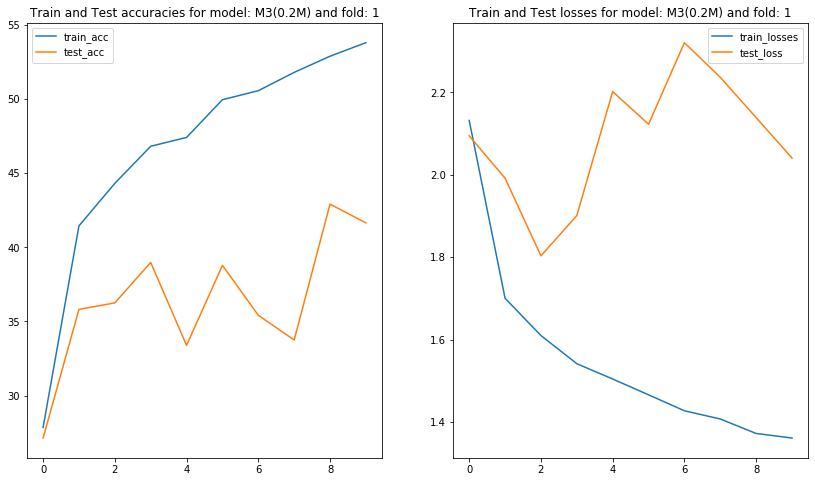

Current K-Fold is: 2 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.2246 train accuracy:28.45  test loss: 1.8183 test accuracy: 28.71
Train Epoch: 2 train loss: 1.7091 train accuracy:40.61  test loss: 1.9170 test accuracy: 29.61
Train Epoch: 3 train loss: 1.6327 train accuracy:43.70  test loss: 1.8499 test accuracy: 31.11
Train Epoch: 4 train loss: 1.5556 train accuracy:46.70  test loss: 1.9917 test accuracy: 27.73
Train Epoch: 5 train loss: 1.4992 train accuracy:48.11  test loss: 1.8462 test accuracy: 36.81
Train Epoch: 6 train loss: 1.4737 train accuracy:49.71  test loss: 1.8929 test accuracy: 33.37
Train Epoch: 7 train loss: 1.4355 train accuracy:51.08  test loss: 1.8947 test accuracy: 37.37
Train Epoch: 8 train loss: 1.4101 train accuracy:52.07  test loss: 1.9078 test accuracy: 37.48
Train Epoch: 9 train loss: 1.3894 train accuracy:52.70  test loss: 2.6592 test accuracy: 31.78
Train Epoch: 10 train loss: 1.3427 train accuracy:54.82  test loss: 2.0907

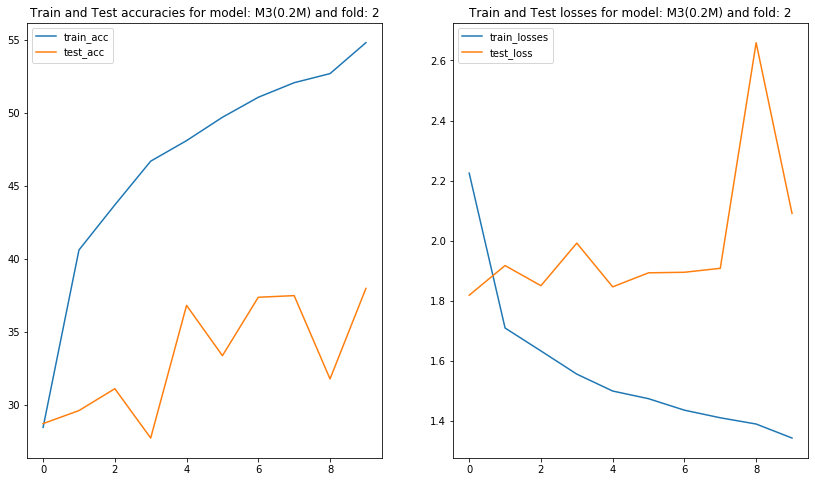

Current K-Fold is: 3 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1351 train accuracy:28.23  test loss: 1.9776 test accuracy: 36.11
Train Epoch: 2 train loss: 1.7231 train accuracy:40.82  test loss: 1.9554 test accuracy: 41.88
Train Epoch: 3 train loss: 1.6340 train accuracy:43.88  test loss: 1.9081 test accuracy: 40.82
Train Epoch: 4 train loss: 1.5326 train accuracy:46.36  test loss: 1.8950 test accuracy: 36.20
Train Epoch: 5 train loss: 1.4840 train accuracy:48.23  test loss: 2.0385 test accuracy: 40.13
Train Epoch: 6 train loss: 1.4849 train accuracy:48.21  test loss: 2.0512 test accuracy: 38.38
Train Epoch: 7 train loss: 1.4562 train accuracy:49.53  test loss: 2.1255 test accuracy: 37.49
Train Epoch: 8 train loss: 1.4191 train accuracy:50.62  test loss: 1.9532 test accuracy: 38.74
Train Epoch: 9 train loss: 1.3991 train accuracy:51.26  test loss: 1.9502 test accuracy: 39.66
Train Epoch: 10 train loss: 1.3856 train accuracy:52.62  test loss: 2.0881

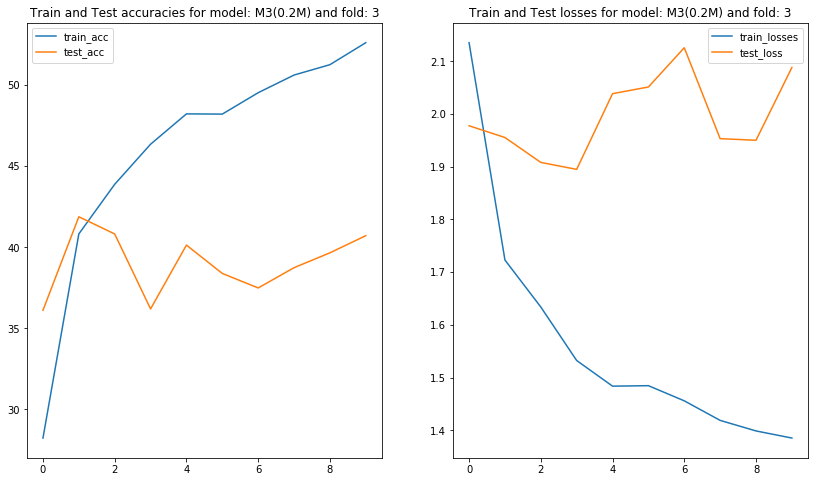

Current K-Fold is: 4 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1503 train accuracy:28.05  test loss: 2.1241 test accuracy: 27.98
Train Epoch: 2 train loss: 1.7432 train accuracy:39.05  test loss: 2.0649 test accuracy: 34.54
Train Epoch: 3 train loss: 1.6420 train accuracy:42.25  test loss: 1.8130 test accuracy: 41.04
Train Epoch: 4 train loss: 1.5653 train accuracy:44.75  test loss: 1.8852 test accuracy: 38.91
Train Epoch: 5 train loss: 1.5100 train accuracy:47.25  test loss: 1.7578 test accuracy: 40.74
Train Epoch: 6 train loss: 1.4583 train accuracy:48.59  test loss: 1.8651 test accuracy: 37.70
Train Epoch: 7 train loss: 1.4530 train accuracy:48.97  test loss: 1.8625 test accuracy: 38.72
Train Epoch: 8 train loss: 1.4076 train accuracy:50.93  test loss: 1.8579 test accuracy: 42.32
Train Epoch: 9 train loss: 1.4088 train accuracy:51.39  test loss: 1.7922 test accuracy: 43.61
Train Epoch: 10 train loss: 1.3741 train accuracy:52.14  test loss: 1.9081

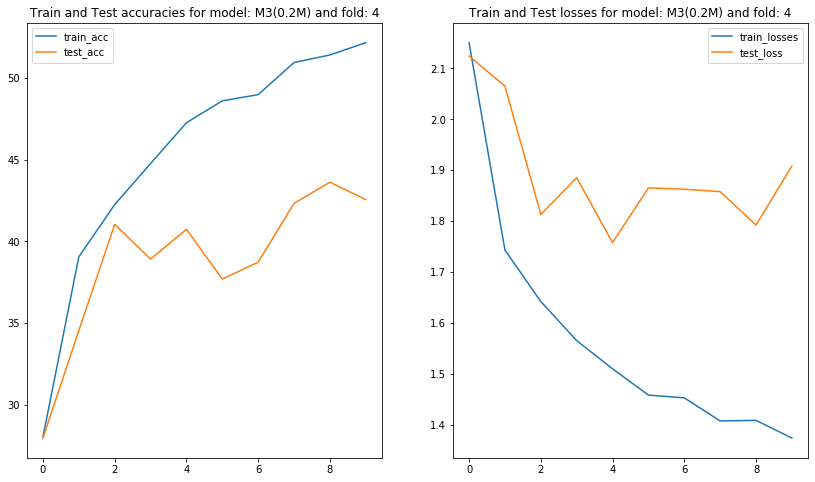

Current K-Fold is: 5 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1067 train accuracy:28.03  test loss: 2.1122 test accuracy: 25.65
Train Epoch: 2 train loss: 1.7478 train accuracy:38.16  test loss: 2.1317 test accuracy: 28.56
Train Epoch: 3 train loss: 1.6351 train accuracy:42.43  test loss: 1.9324 test accuracy: 30.79
Train Epoch: 4 train loss: 1.5769 train accuracy:44.83  test loss: 1.8712 test accuracy: 33.71
Train Epoch: 5 train loss: 1.5096 train accuracy:47.17  test loss: 1.8008 test accuracy: 38.56
Train Epoch: 6 train loss: 1.5012 train accuracy:47.30  test loss: 1.6845 test accuracy: 40.56
Train Epoch: 7 train loss: 1.4637 train accuracy:49.34  test loss: 1.7851 test accuracy: 39.50
Train Epoch: 8 train loss: 1.4455 train accuracy:49.56  test loss: 1.8874 test accuracy: 40.06
Train Epoch: 9 train loss: 1.4111 train accuracy:50.82  test loss: 1.9116 test accuracy: 38.56
Train Epoch: 10 train loss: 1.4169 train accuracy:50.50  test loss: 1.8682

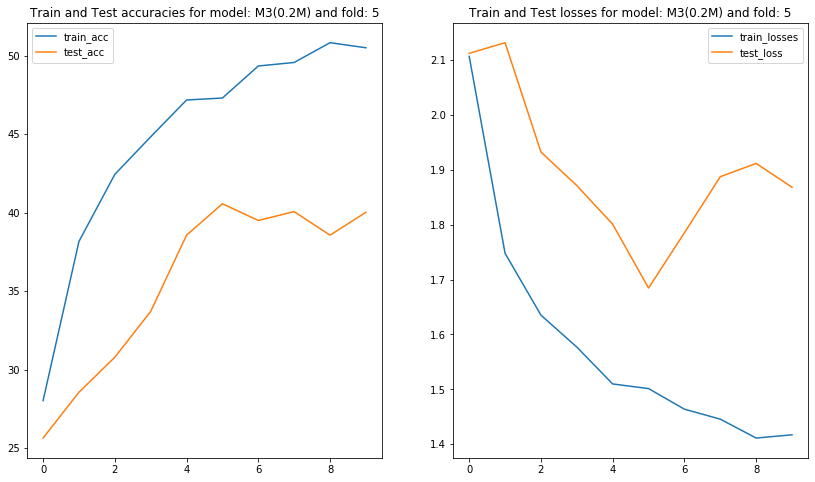

Current K-Fold is: 6 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1424 train accuracy:28.11  test loss: 2.2497 test accuracy: 28.32
Train Epoch: 2 train loss: 1.7033 train accuracy:41.08  test loss: 2.1931 test accuracy: 32.03
Train Epoch: 3 train loss: 1.6115 train accuracy:43.71  test loss: 2.1288 test accuracy: 35.53
Train Epoch: 4 train loss: 1.5352 train accuracy:46.74  test loss: 2.3137 test accuracy: 26.98
Train Epoch: 5 train loss: 1.5127 train accuracy:47.84  test loss: 2.2634 test accuracy: 32.51
Train Epoch: 6 train loss: 1.4759 train accuracy:49.16  test loss: 2.0055 test accuracy: 43.94
Train Epoch: 7 train loss: 1.4327 train accuracy:50.54  test loss: 2.1847 test accuracy: 32.29
Train Epoch: 8 train loss: 1.3881 train accuracy:52.56  test loss: 2.1753 test accuracy: 32.41
Train Epoch: 9 train loss: 1.3793 train accuracy:52.50  test loss: 2.4802 test accuracy: 31.93
Train Epoch: 10 train loss: 1.3578 train accuracy:53.70  test loss: 2.2008

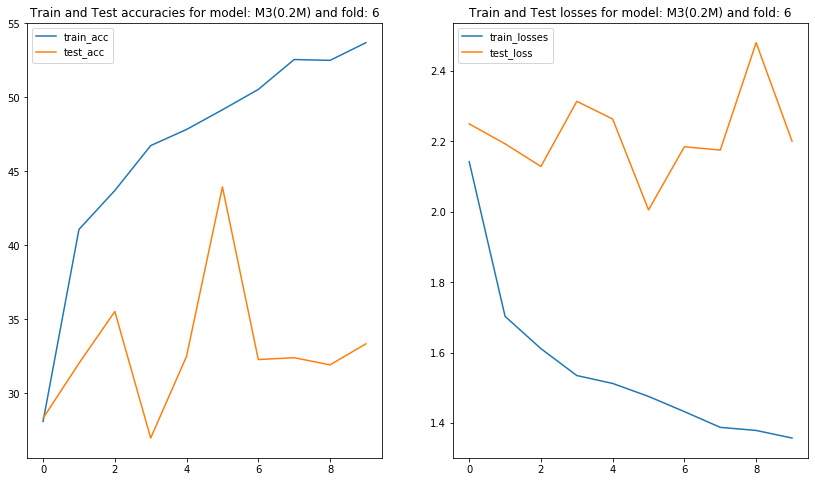

Current K-Fold is: 7 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1199 train accuracy:29.82  test loss: 1.9839 test accuracy: 23.44
Train Epoch: 2 train loss: 1.7213 train accuracy:40.80  test loss: 1.8274 test accuracy: 35.04
Train Epoch: 3 train loss: 1.6540 train accuracy:42.96  test loss: 1.6667 test accuracy: 35.60
Train Epoch: 4 train loss: 1.5751 train accuracy:45.94  test loss: 1.5076 test accuracy: 42.75
Train Epoch: 5 train loss: 1.5563 train accuracy:46.65  test loss: 1.6354 test accuracy: 37.05
Train Epoch: 6 train loss: 1.5160 train accuracy:48.62  test loss: 1.5727 test accuracy: 41.70
Train Epoch: 7 train loss: 1.4745 train accuracy:48.79  test loss: 1.4194 test accuracy: 48.66
Train Epoch: 8 train loss: 1.4314 train accuracy:51.06  test loss: 1.6448 test accuracy: 38.17
Train Epoch: 9 train loss: 1.4259 train accuracy:51.16  test loss: 1.6530 test accuracy: 43.64
Train Epoch: 10 train loss: 1.4157 train accuracy:50.51  test loss: 1.5527

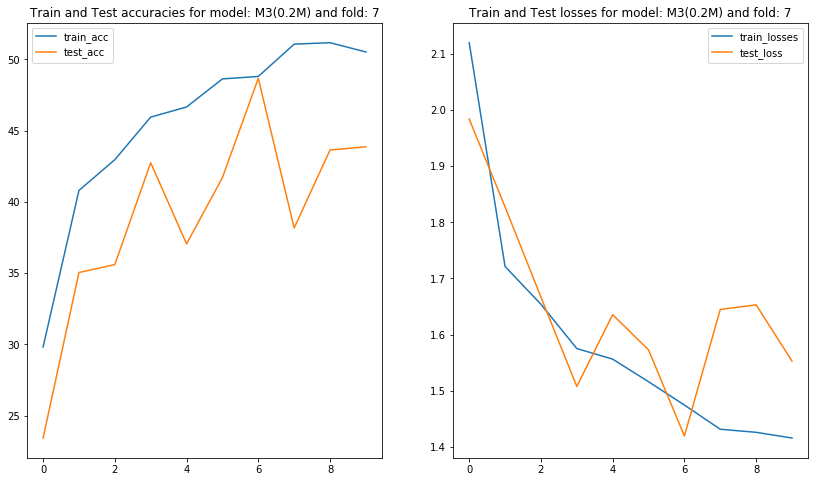

Current K-Fold is: 8 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.2452 train accuracy:24.46  test loss: 2.0405 test accuracy: 36.48
Train Epoch: 2 train loss: 1.7243 train accuracy:39.10  test loss: 1.9527 test accuracy: 28.18
Train Epoch: 3 train loss: 1.6026 train accuracy:44.02  test loss: 1.9395 test accuracy: 38.28
Train Epoch: 4 train loss: 1.5426 train accuracy:46.08  test loss: 2.0334 test accuracy: 37.56
Train Epoch: 5 train loss: 1.4920 train accuracy:47.67  test loss: 1.9479 test accuracy: 38.32
Train Epoch: 6 train loss: 1.4692 train accuracy:49.05  test loss: 1.9689 test accuracy: 41.55
Train Epoch: 7 train loss: 1.4349 train accuracy:49.41  test loss: 1.8881 test accuracy: 43.38
Train Epoch: 8 train loss: 1.4040 train accuracy:51.18  test loss: 2.0558 test accuracy: 36.96
Train Epoch: 9 train loss: 1.4044 train accuracy:50.75  test loss: 1.9600 test accuracy: 38.68
Train Epoch: 10 train loss: 1.3678 train accuracy:51.99  test loss: 2.0425

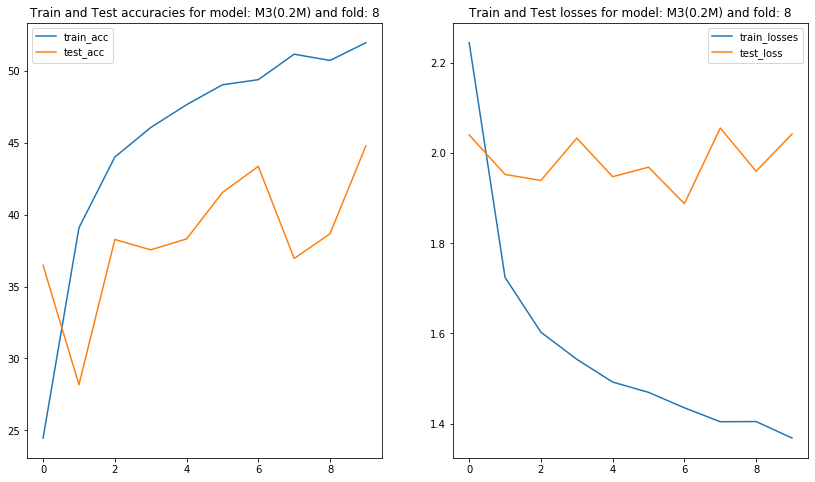

Current K-Fold is: 9 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1179 train accuracy:30.20  test loss: 2.2603 test accuracy: 30.81
Train Epoch: 2 train loss: 1.7183 train accuracy:40.35  test loss: 2.5125 test accuracy: 28.41
Train Epoch: 3 train loss: 1.6070 train accuracy:44.63  test loss: 1.9806 test accuracy: 35.30
Train Epoch: 4 train loss: 1.5586 train accuracy:46.36  test loss: 1.8798 test accuracy: 34.82
Train Epoch: 5 train loss: 1.4956 train accuracy:48.63  test loss: 2.2337 test accuracy: 40.38
Train Epoch: 6 train loss: 1.5018 train accuracy:48.09  test loss: 2.3067 test accuracy: 36.42
Train Epoch: 7 train loss: 1.4632 train accuracy:50.25  test loss: 2.0268 test accuracy: 39.86
Train Epoch: 8 train loss: 1.4326 train accuracy:50.44  test loss: 2.1195 test accuracy: 40.06
Train Epoch: 9 train loss: 1.4027 train accuracy:51.69  test loss: 2.0963 test accuracy: 47.00
Train Epoch: 10 train loss: 1.3856 train accuracy:52.41  test loss: 2.1845

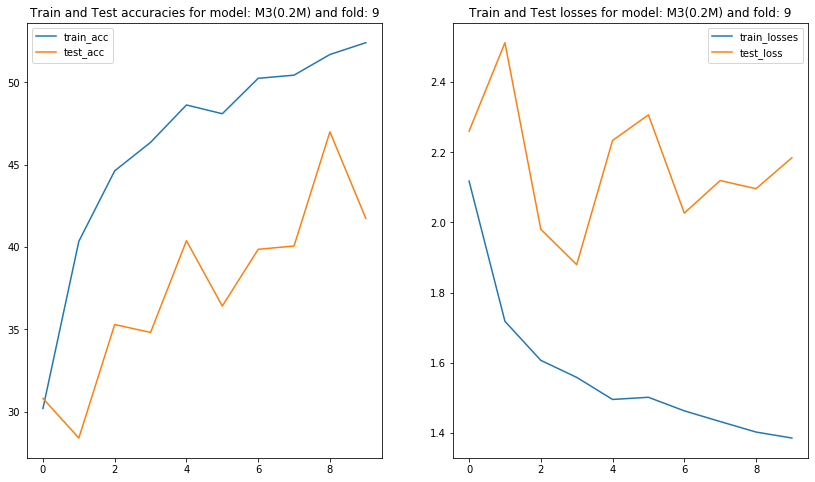

Current K-Fold is: 10 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.1901 train accuracy:27.36  test loss: 1.9047 test accuracy: 22.75
Train Epoch: 2 train loss: 1.7350 train accuracy:39.09  test loss: 1.7508 test accuracy: 37.17
Train Epoch: 3 train loss: 1.6168 train accuracy:43.74  test loss: 1.7683 test accuracy: 36.23
Train Epoch: 4 train loss: 1.5795 train accuracy:45.61  test loss: 1.6599 test accuracy: 38.42
Train Epoch: 5 train loss: 1.5183 train accuracy:47.67  test loss: 1.6270 test accuracy: 44.71
Train Epoch: 6 train loss: 1.4983 train accuracy:47.86  test loss: 1.6766 test accuracy: 41.58
Train Epoch: 7 train loss: 1.4440 train accuracy:50.23  test loss: 1.7358 test accuracy: 39.20
Train Epoch: 8 train loss: 1.4392 train accuracy:50.42  test loss: 1.5042 test accuracy: 44.89
Train Epoch: 9 train loss: 1.4251 train accuracy:51.12  test loss: 1.6314 test accuracy: 44.38
Train Epoch: 10 train loss: 1.4020 train accuracy:52.24  test loss: 1.679

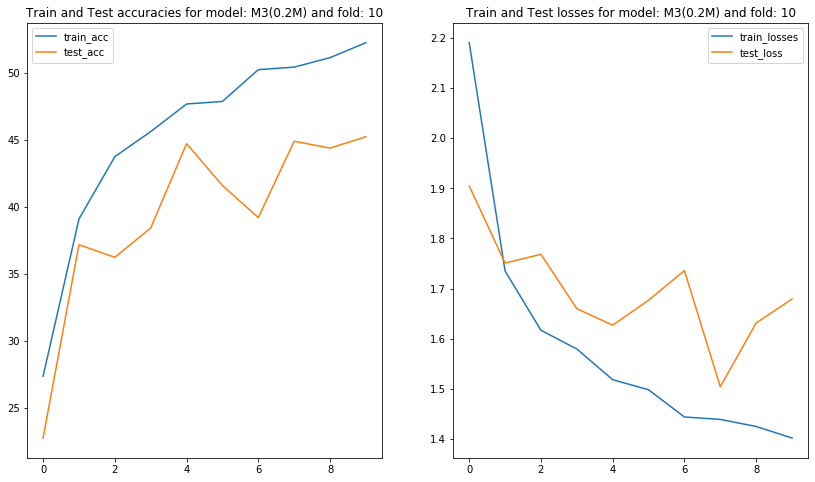

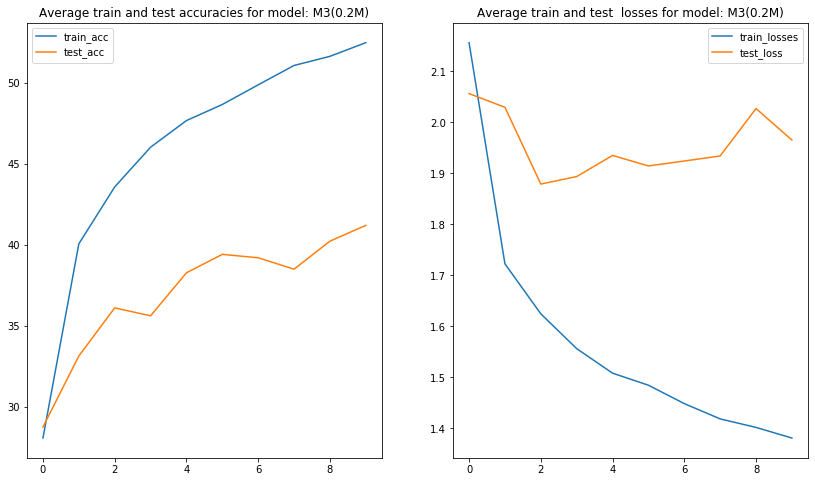

In [0]:
train_all_folds(M3, "M3(0.2M)")

Current K-Fold is: 1 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.4180 train accuracy:28.13  test loss: 1.7820 test accuracy: 37.85
Train Epoch: 2 train loss: 1.7157 train accuracy:41.16  test loss: 1.6760 test accuracy: 45.57
Train Epoch: 3 train loss: 1.5364 train accuracy:46.81  test loss: 1.9526 test accuracy: 35.43
Train Epoch: 4 train loss: 1.3915 train accuracy:52.18  test loss: 2.4328 test accuracy: 40.86
Train Epoch: 5 train loss: 1.2524 train accuracy:57.44  test loss: 2.7389 test accuracy: 36.44
Train Epoch: 6 train loss: 1.1624 train accuracy:62.19  test loss: 2.0113 test accuracy: 39.19
Train Epoch: 7 train loss: 1.0626 train accuracy:64.85  test loss: 1.9645 test accuracy: 39.08
Train Epoch: 8 train loss: 1.0006 train accuracy:67.37  test loss: 2.2537 test accuracy: 45.06
Train Epoch: 9 train loss: 0.9600 train accuracy:68.16  test loss: 2.0909 test accuracy: 45.85
Train Epoch: 10 train loss: 0.9219 train accuracy:69.27  test loss: 2.2921

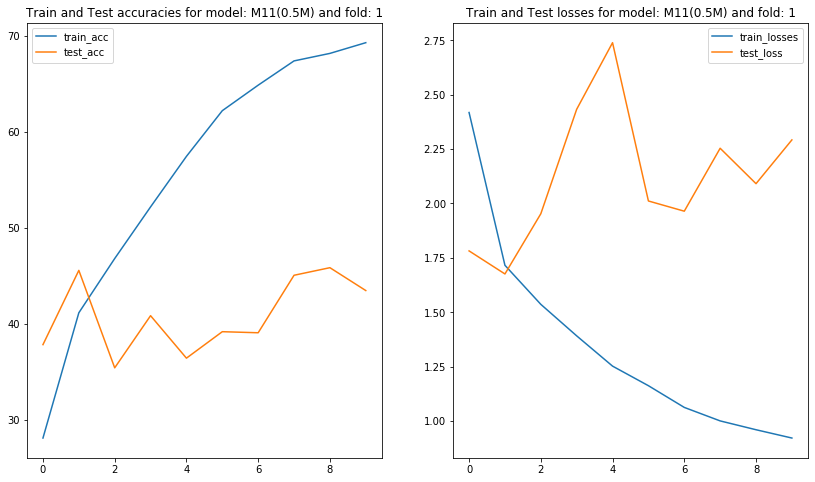

Current K-Fold is: 2 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3335 train accuracy:28.87  test loss: 2.8431 test accuracy: 21.06
Train Epoch: 2 train loss: 1.6691 train accuracy:42.59  test loss: 1.9521 test accuracy: 32.57
Train Epoch: 3 train loss: 1.4669 train accuracy:50.43  test loss: 1.7845 test accuracy: 40.59
Train Epoch: 4 train loss: 1.3300 train accuracy:55.85  test loss: 2.4040 test accuracy: 26.20
Train Epoch: 5 train loss: 1.2115 train accuracy:59.66  test loss: 2.1559 test accuracy: 38.15
Train Epoch: 6 train loss: 1.1092 train accuracy:62.61  test loss: 2.1214 test accuracy: 38.79
Train Epoch: 7 train loss: 1.0417 train accuracy:64.63  test loss: 2.0419 test accuracy: 39.52
Train Epoch: 8 train loss: 0.9816 train accuracy:67.01  test loss: 2.5680 test accuracy: 40.69
Train Epoch: 9 train loss: 0.9399 train accuracy:68.77  test loss: 1.9043 test accuracy: 39.97
Train Epoch: 10 train loss: 0.9078 train accuracy:69.85  test loss: 1.7232

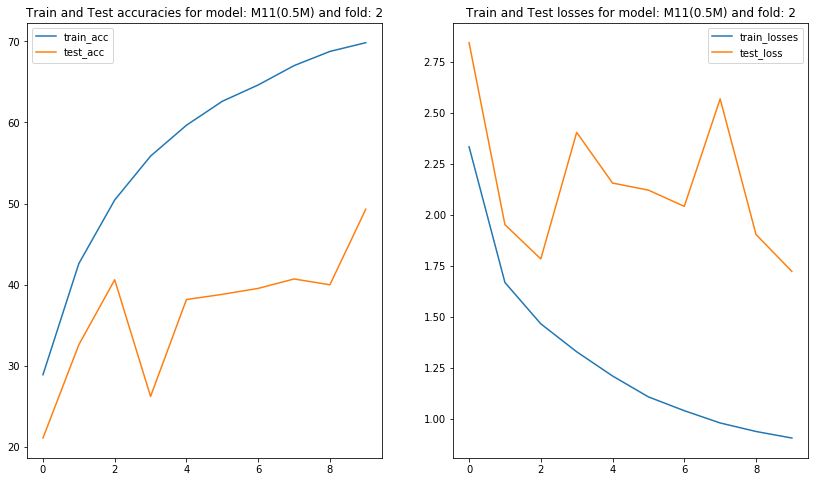

Current K-Fold is: 3 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3097 train accuracy:28.57  test loss: 1.8732 test accuracy: 39.22
Train Epoch: 2 train loss: 1.7129 train accuracy:40.10  test loss: 2.0696 test accuracy: 35.92
Train Epoch: 3 train loss: 1.4720 train accuracy:49.27  test loss: 1.7830 test accuracy: 49.41
Train Epoch: 4 train loss: 1.3273 train accuracy:54.85  test loss: 2.0973 test accuracy: 41.61
Train Epoch: 5 train loss: 1.1740 train accuracy:60.28  test loss: 2.1687 test accuracy: 40.53
Train Epoch: 6 train loss: 1.0841 train accuracy:63.60  test loss: 2.1836 test accuracy: 44.74
Train Epoch: 7 train loss: 1.0193 train accuracy:66.13  test loss: 2.2550 test accuracy: 42.18
Train Epoch: 8 train loss: 0.9753 train accuracy:68.52  test loss: 2.6155 test accuracy: 47.09
Train Epoch: 9 train loss: 0.9165 train accuracy:69.77  test loss: 2.3926 test accuracy: 45.51
Train Epoch: 10 train loss: 0.9002 train accuracy:69.90  test loss: 2.0232

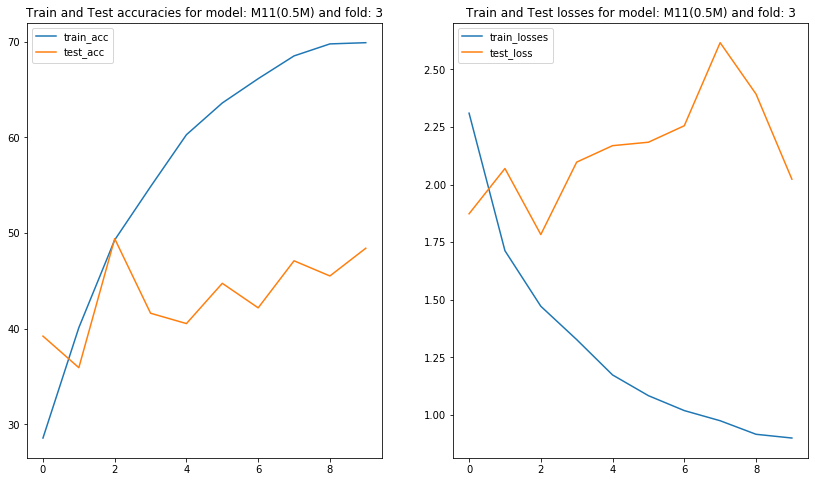

Current K-Fold is: 4 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3745 train accuracy:25.42  test loss: 2.0986 test accuracy: 30.00
Train Epoch: 2 train loss: 1.7343 train accuracy:37.92  test loss: 1.9373 test accuracy: 37.10
Train Epoch: 3 train loss: 1.5203 train accuracy:46.86  test loss: 1.7560 test accuracy: 41.96
Train Epoch: 4 train loss: 1.3714 train accuracy:51.72  test loss: 1.7885 test accuracy: 40.98
Train Epoch: 5 train loss: 1.2399 train accuracy:57.73  test loss: 1.7898 test accuracy: 43.50
Train Epoch: 6 train loss: 1.1694 train accuracy:60.38  test loss: 1.4899 test accuracy: 53.70
Train Epoch: 7 train loss: 1.1165 train accuracy:62.71  test loss: 1.9179 test accuracy: 47.07
Train Epoch: 8 train loss: 1.0528 train accuracy:64.83  test loss: 1.8173 test accuracy: 52.19
Train Epoch: 9 train loss: 0.9745 train accuracy:67.42  test loss: 1.6098 test accuracy: 55.72
Train Epoch: 10 train loss: 0.9285 train accuracy:69.05  test loss: 1.4438

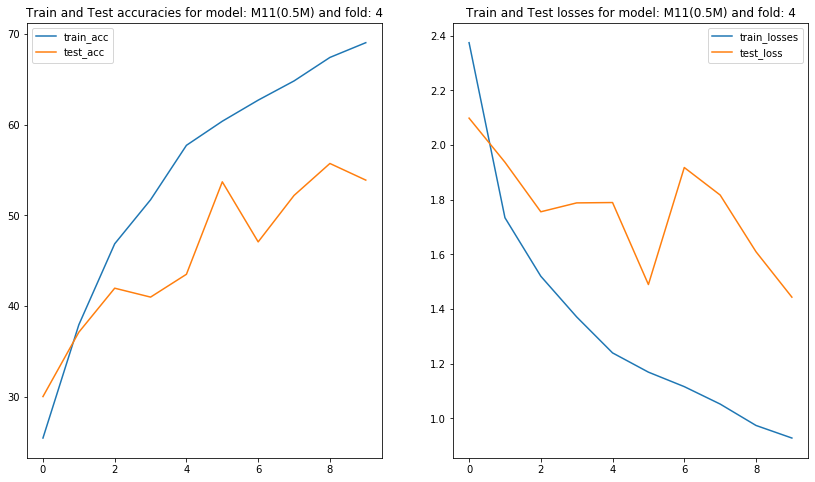

Current K-Fold is: 5 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3596 train accuracy:27.04  test loss: 1.9449 test accuracy: 25.38
Train Epoch: 2 train loss: 1.7094 train accuracy:39.96  test loss: 1.7790 test accuracy: 34.83
Train Epoch: 3 train loss: 1.5555 train accuracy:46.10  test loss: 1.6454 test accuracy: 38.62
Train Epoch: 4 train loss: 1.3626 train accuracy:52.86  test loss: 1.5939 test accuracy: 39.65
Train Epoch: 5 train loss: 1.2419 train accuracy:58.31  test loss: 1.4316 test accuracy: 50.90
Train Epoch: 6 train loss: 1.1563 train accuracy:61.76  test loss: 2.0861 test accuracy: 42.73
Train Epoch: 7 train loss: 1.0798 train accuracy:64.37  test loss: 1.5859 test accuracy: 46.75
Train Epoch: 8 train loss: 1.0251 train accuracy:66.02  test loss: 1.6435 test accuracy: 48.48
Train Epoch: 9 train loss: 0.9677 train accuracy:67.87  test loss: 1.6470 test accuracy: 51.65
Train Epoch: 10 train loss: 0.9267 train accuracy:69.86  test loss: 1.7612

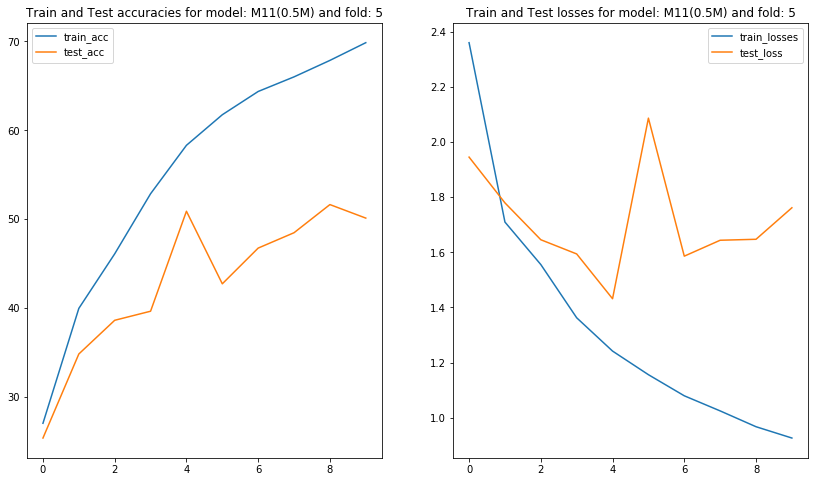

Current K-Fold is: 6 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3219 train accuracy:30.69  test loss: 1.9955 test accuracy: 31.11
Train Epoch: 2 train loss: 1.6615 train accuracy:42.77  test loss: 1.9291 test accuracy: 37.59
Train Epoch: 3 train loss: 1.4354 train accuracy:51.30  test loss: 1.8519 test accuracy: 42.08
Train Epoch: 4 train loss: 1.2928 train accuracy:55.52  test loss: 2.0507 test accuracy: 33.55
Train Epoch: 5 train loss: 1.1789 train accuracy:60.82  test loss: 1.9841 test accuracy: 49.65
Train Epoch: 6 train loss: 1.1094 train accuracy:62.89  test loss: 1.5684 test accuracy: 55.70
Train Epoch: 7 train loss: 1.0265 train accuracy:65.52  test loss: 1.9371 test accuracy: 45.50
Train Epoch: 8 train loss: 0.9620 train accuracy:68.16  test loss: 1.7732 test accuracy: 47.11
Train Epoch: 9 train loss: 0.9386 train accuracy:69.11  test loss: 2.0963 test accuracy: 45.77
Train Epoch: 10 train loss: 0.9079 train accuracy:70.08  test loss: 1.8082

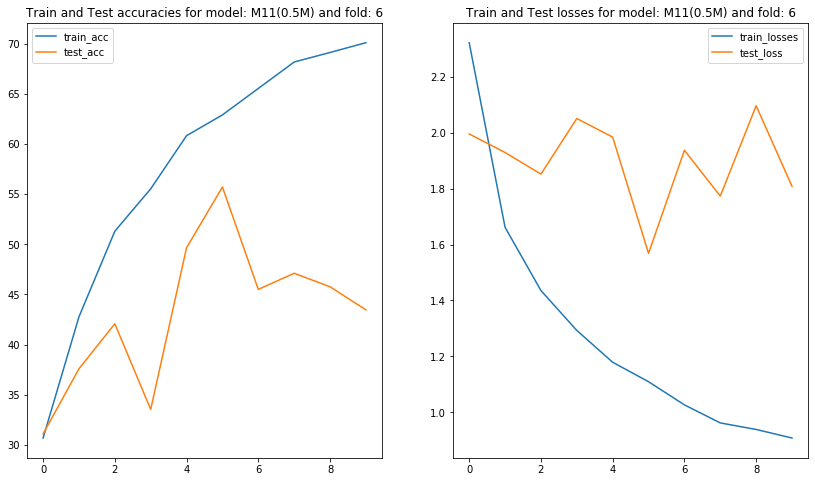

Current K-Fold is: 7 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.4360 train accuracy:25.55  test loss: 1.8599 test accuracy: 30.25
Train Epoch: 2 train loss: 1.6792 train accuracy:42.05  test loss: 1.8992 test accuracy: 28.35
Train Epoch: 3 train loss: 1.4724 train accuracy:49.03  test loss: 1.8679 test accuracy: 37.28
Train Epoch: 4 train loss: 1.3645 train accuracy:53.78  test loss: 1.6940 test accuracy: 39.84
Train Epoch: 5 train loss: 1.2340 train accuracy:59.08  test loss: 1.9257 test accuracy: 39.40
Train Epoch: 6 train loss: 1.1478 train accuracy:61.89  test loss: 1.5863 test accuracy: 50.45
Train Epoch: 7 train loss: 1.0667 train accuracy:64.74  test loss: 1.9349 test accuracy: 42.52
Train Epoch: 8 train loss: 0.9913 train accuracy:67.13  test loss: 1.6346 test accuracy: 45.87
Train Epoch: 9 train loss: 0.9518 train accuracy:68.63  test loss: 1.9663 test accuracy: 45.54
Train Epoch: 10 train loss: 0.9353 train accuracy:69.50  test loss: 1.6272

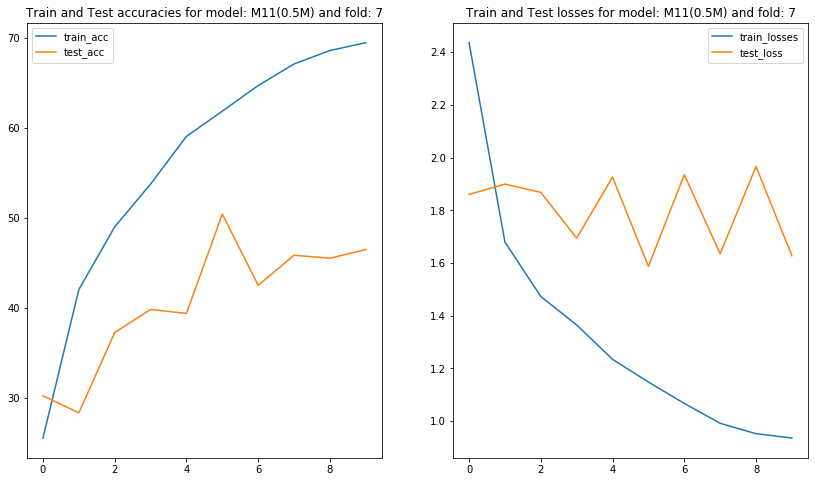

Current K-Fold is: 8 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.2665 train accuracy:28.19  test loss: 2.2481 test accuracy: 30.33
Train Epoch: 2 train loss: 1.6373 train accuracy:42.09  test loss: 1.9005 test accuracy: 48.20
Train Epoch: 3 train loss: 1.4508 train accuracy:50.04  test loss: 2.1246 test accuracy: 41.64
Train Epoch: 4 train loss: 1.3053 train accuracy:55.89  test loss: 2.2486 test accuracy: 42.11
Train Epoch: 5 train loss: 1.2021 train accuracy:59.58  test loss: 2.3580 test accuracy: 37.83
Train Epoch: 6 train loss: 1.1185 train accuracy:62.37  test loss: 2.4602 test accuracy: 40.09
Train Epoch: 7 train loss: 1.0546 train accuracy:64.84  test loss: 2.5085 test accuracy: 40.60
Train Epoch: 8 train loss: 0.9810 train accuracy:67.33  test loss: 2.0569 test accuracy: 42.52
Train Epoch: 9 train loss: 0.9381 train accuracy:68.77  test loss: 2.1191 test accuracy: 47.34
Train Epoch: 10 train loss: 0.9018 train accuracy:69.79  test loss: 3.5752

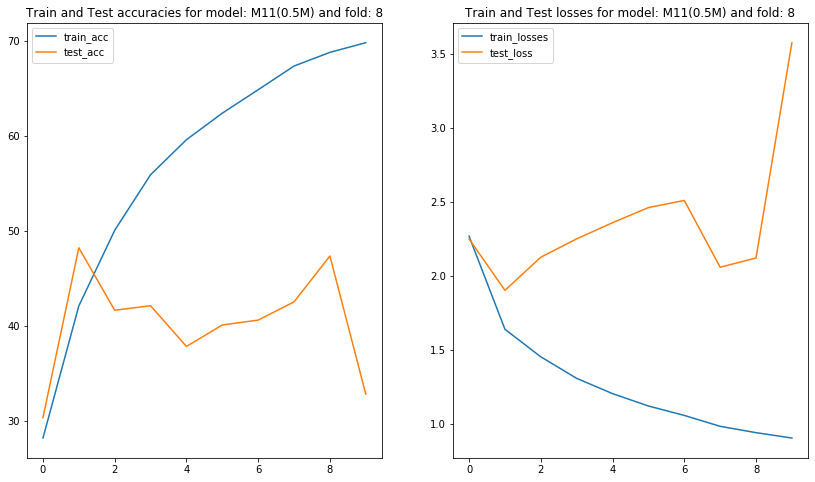

Current K-Fold is: 9 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3847 train accuracy:26.67  test loss: 2.0171 test accuracy: 27.72
Train Epoch: 2 train loss: 1.7507 train accuracy:38.14  test loss: 1.5409 test accuracy: 44.35
Train Epoch: 3 train loss: 1.5066 train accuracy:47.98  test loss: 1.7163 test accuracy: 43.75
Train Epoch: 4 train loss: 1.3343 train accuracy:55.04  test loss: 1.7890 test accuracy: 44.75
Train Epoch: 5 train loss: 1.2383 train accuracy:59.34  test loss: 1.7338 test accuracy: 50.60
Train Epoch: 6 train loss: 1.1488 train accuracy:61.53  test loss: 2.0252 test accuracy: 43.47
Train Epoch: 7 train loss: 1.0700 train accuracy:64.77  test loss: 2.0117 test accuracy: 46.23
Train Epoch: 8 train loss: 0.9920 train accuracy:67.23  test loss: 1.9741 test accuracy: 47.80
Train Epoch: 9 train loss: 0.9716 train accuracy:68.43  test loss: 2.1359 test accuracy: 55.41
Train Epoch: 10 train loss: 0.9387 train accuracy:68.87  test loss: 1.9879

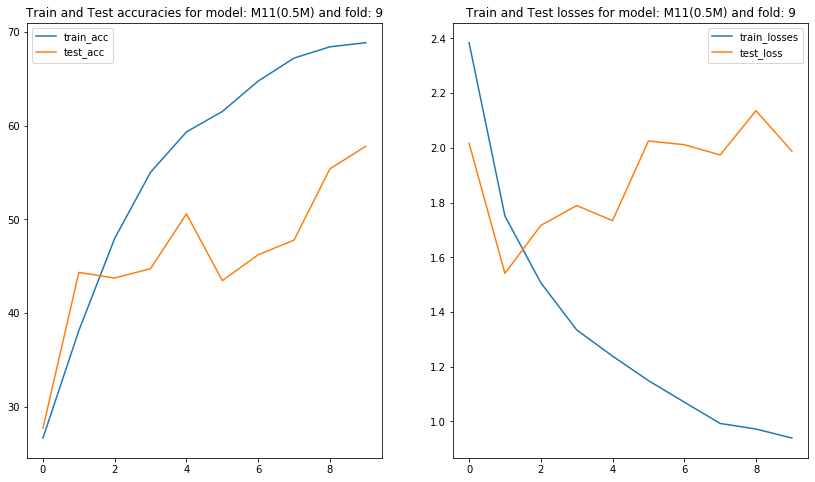

Current K-Fold is: 10 and kwargs:{'num_workers': 8, 'pin_memory': True}
Train Epoch: 1 train loss: 2.3091 train accuracy:27.59  test loss: 2.0441 test accuracy: 26.79
Train Epoch: 2 train loss: 1.7210 train accuracy:39.23  test loss: 1.7141 test accuracy: 45.54
Train Epoch: 3 train loss: 1.5269 train accuracy:47.20  test loss: 1.6792 test accuracy: 41.96
Train Epoch: 4 train loss: 1.3727 train accuracy:52.65  test loss: 1.5923 test accuracy: 46.05
Train Epoch: 5 train loss: 1.2491 train accuracy:57.80  test loss: 1.5433 test accuracy: 51.12
Train Epoch: 6 train loss: 1.1451 train accuracy:61.53  test loss: 1.4359 test accuracy: 48.39
Train Epoch: 7 train loss: 1.0799 train accuracy:63.81  test loss: 1.4944 test accuracy: 55.78
Train Epoch: 8 train loss: 1.0018 train accuracy:66.30  test loss: 1.2713 test accuracy: 61.94
Train Epoch: 9 train loss: 0.9686 train accuracy:67.87  test loss: 1.6536 test accuracy: 61.61
Train Epoch: 10 train loss: 0.9508 train accuracy:68.67  test loss: 1.454

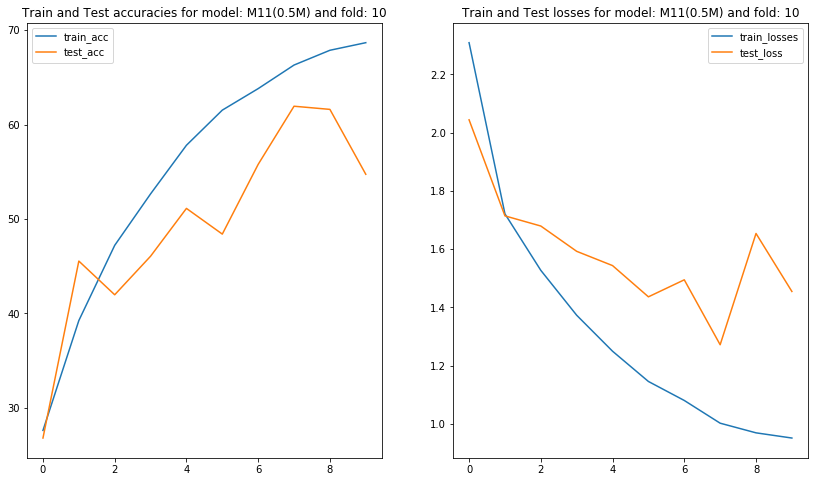

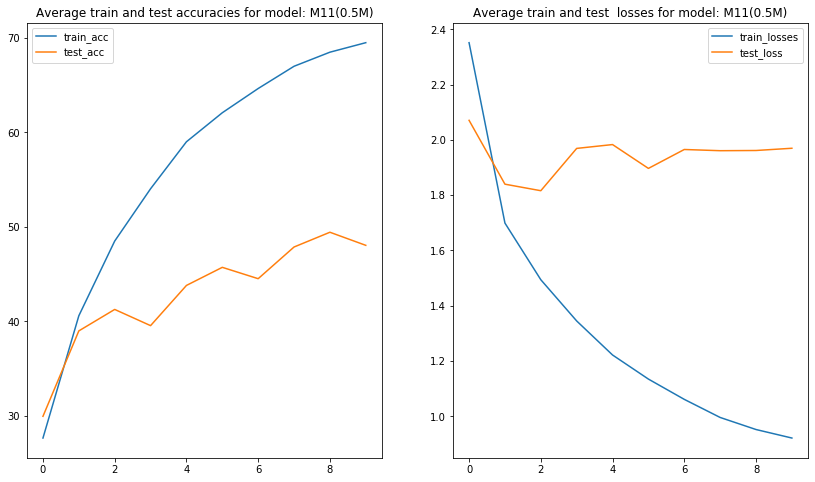

In [0]:
train_all_folds(M5, "M11(0.5M)")

In [0]:
train_all_folds(M11, "M11(1.8M)")

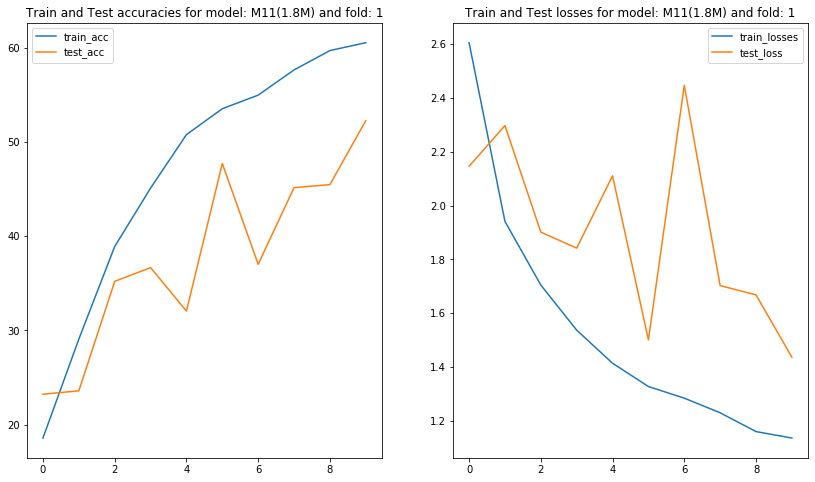

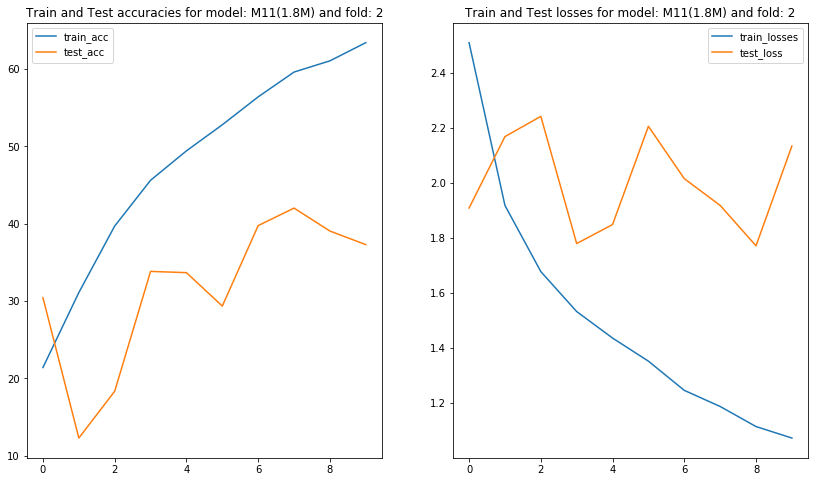

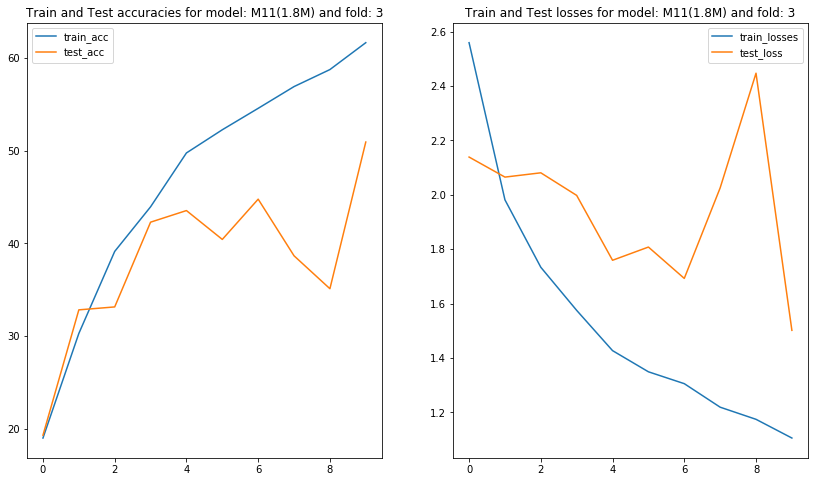

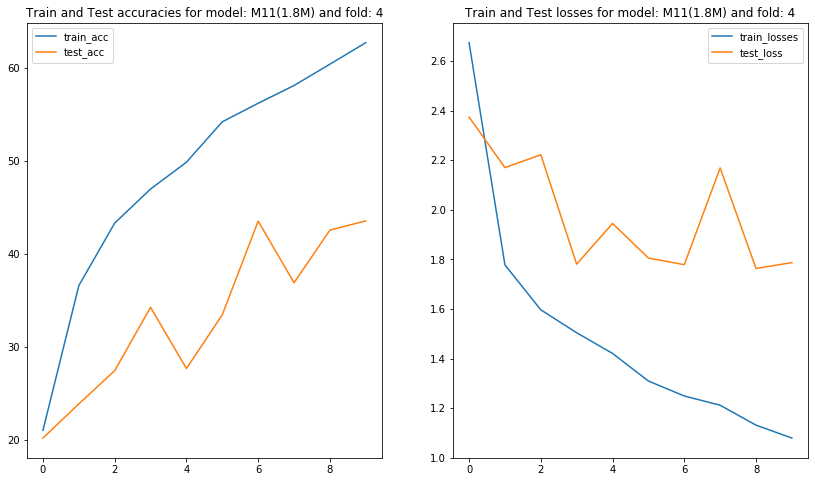

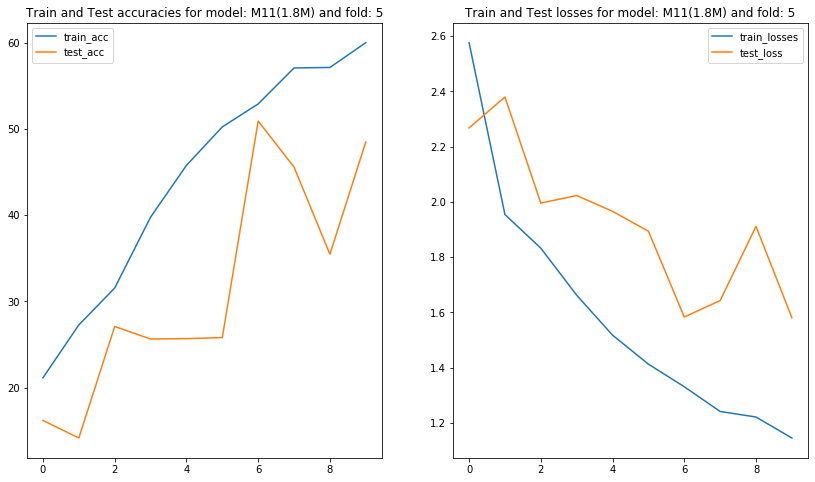

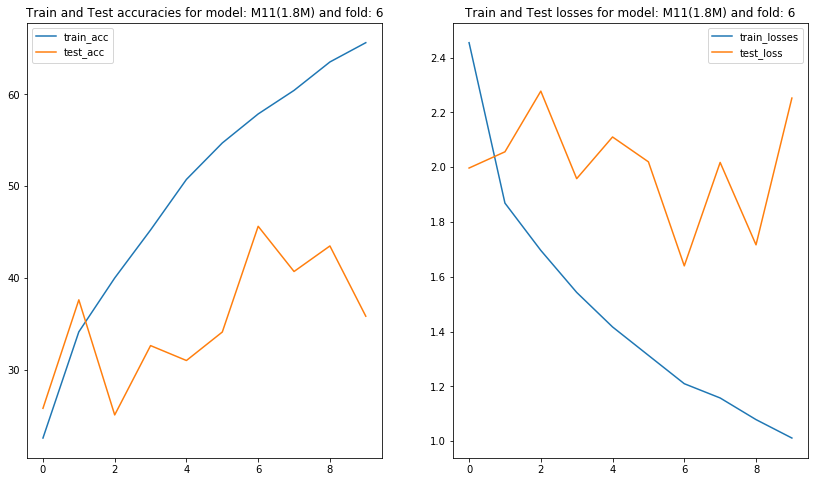

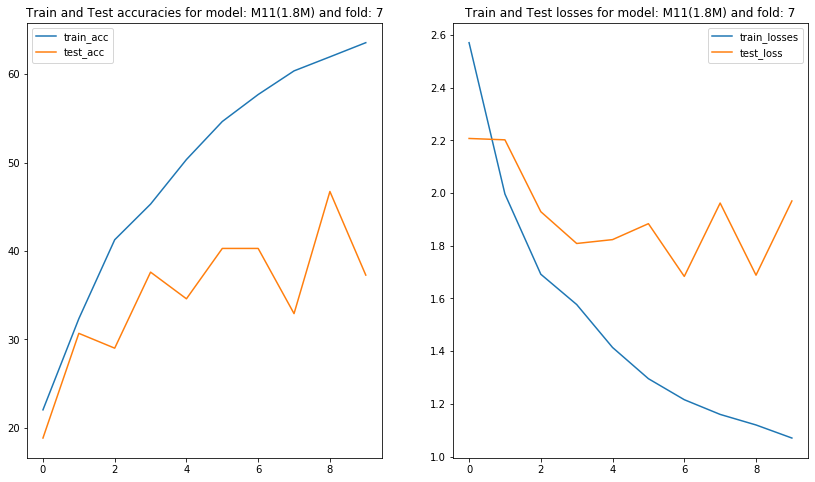

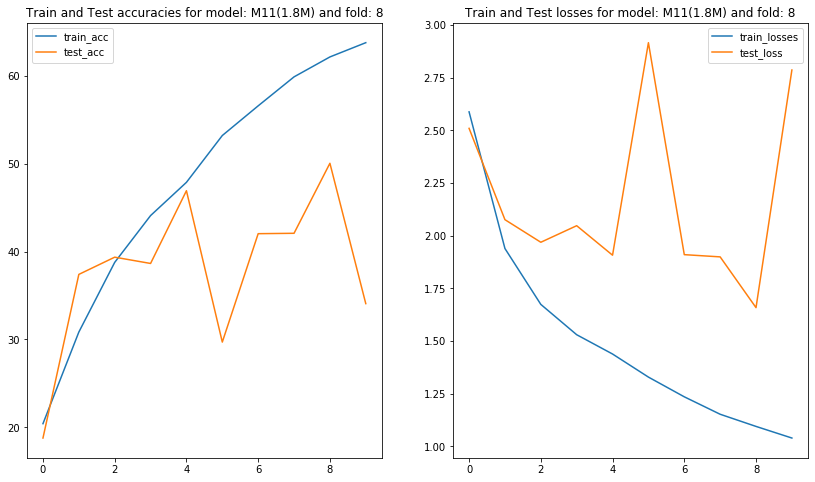

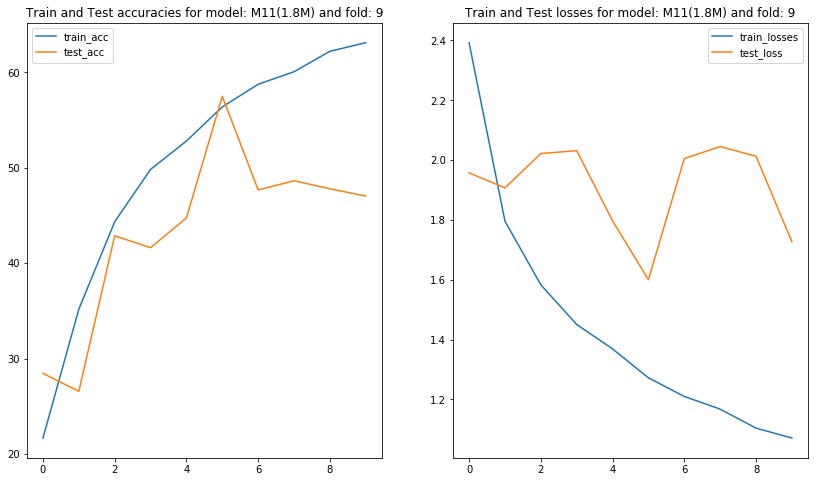

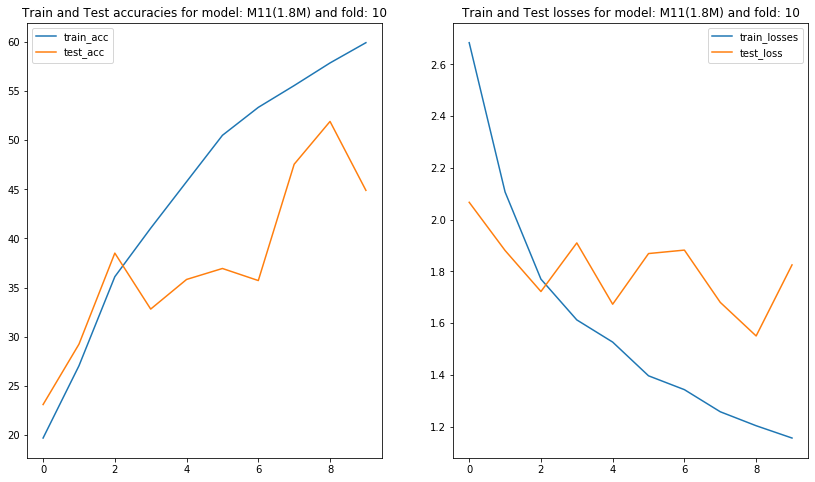

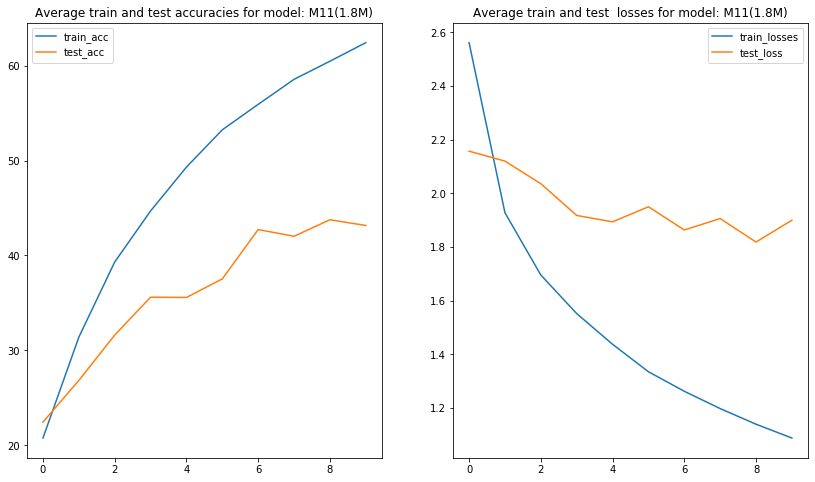

In [0]:
from IPython.display import Image
from IPython.core.display import Image, display
for i in range(1, 11):
  display(Image("/content/drive/My Drive/AudioClassifier/M11/fold{}.png".format(i)))
display(Image("/content/drive/My Drive/AudioClassifier/M11/avg.png"))


In [0]:
train_all_folds(M18, "M18(3.7M)")

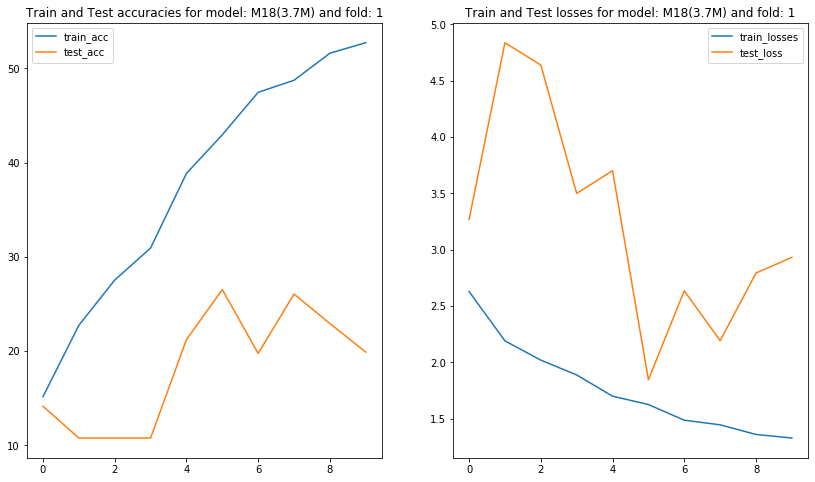

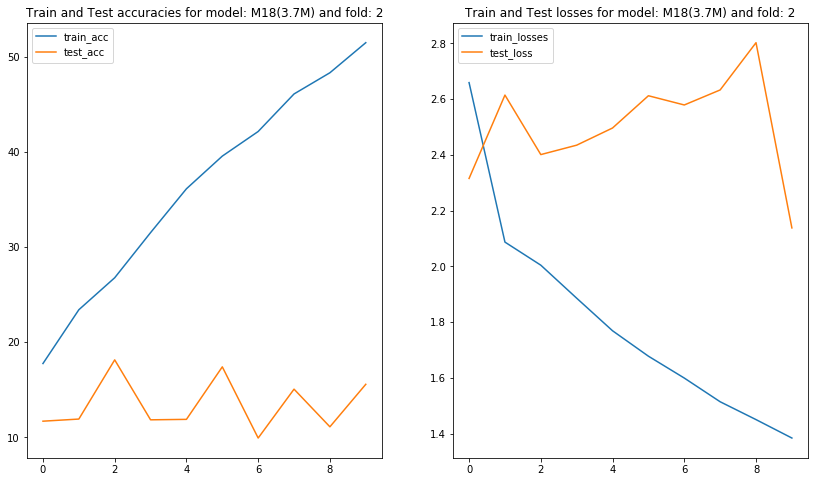

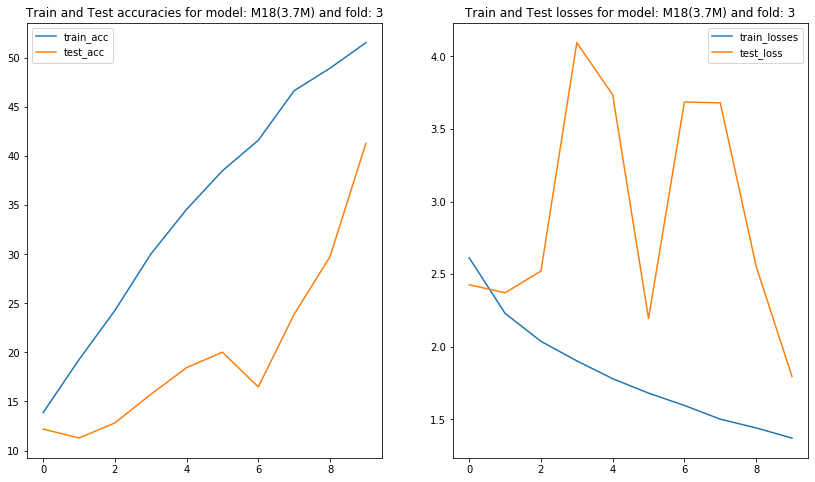

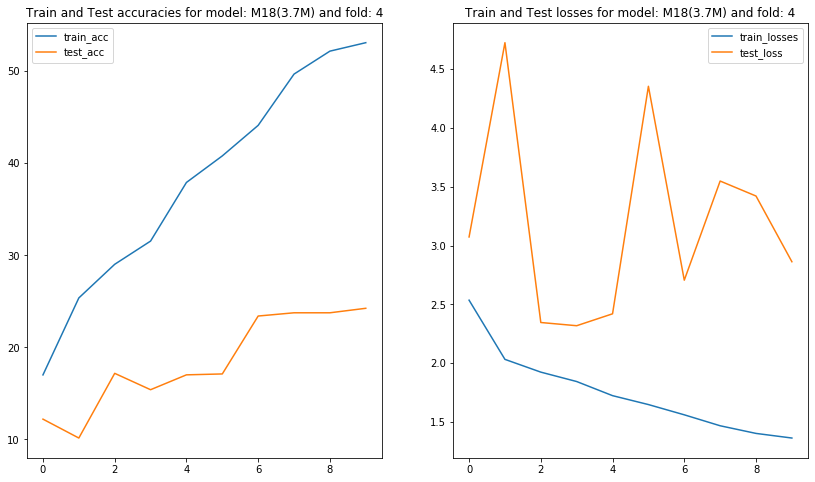

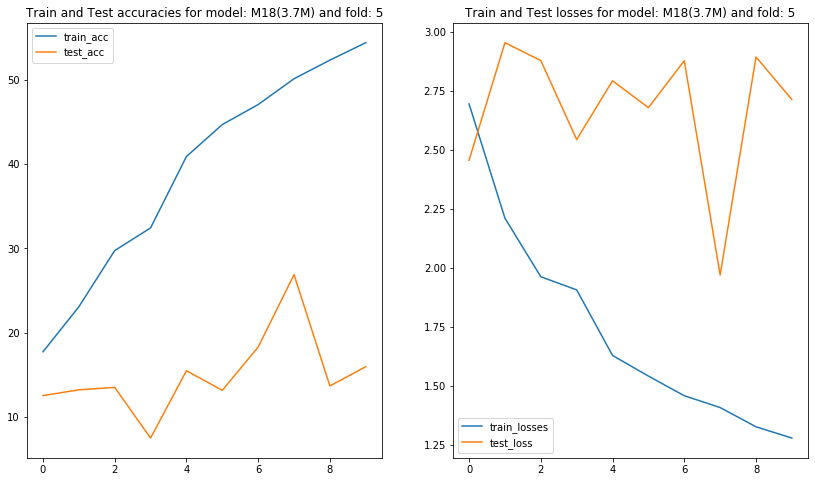

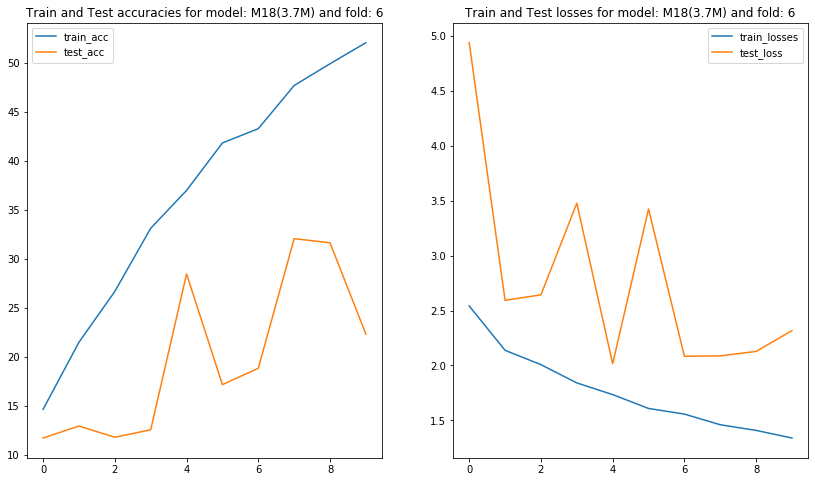

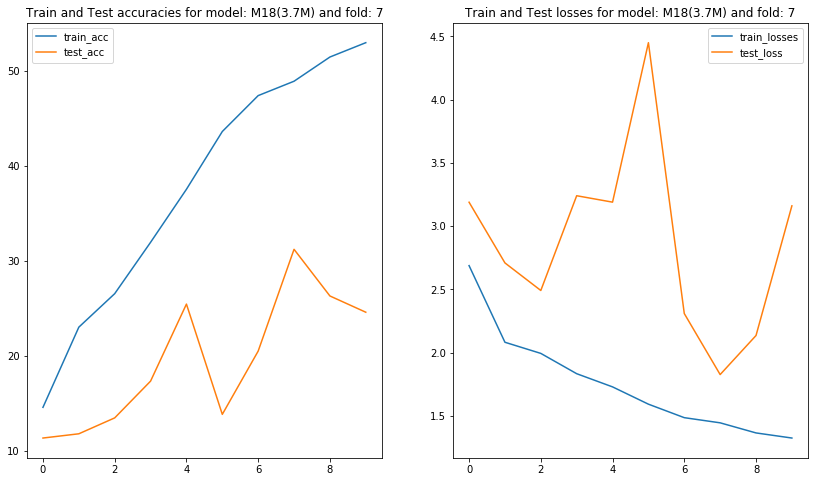

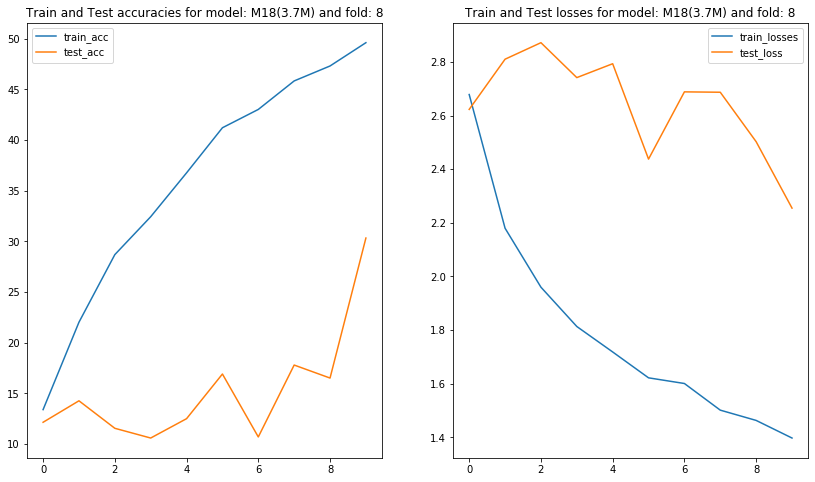

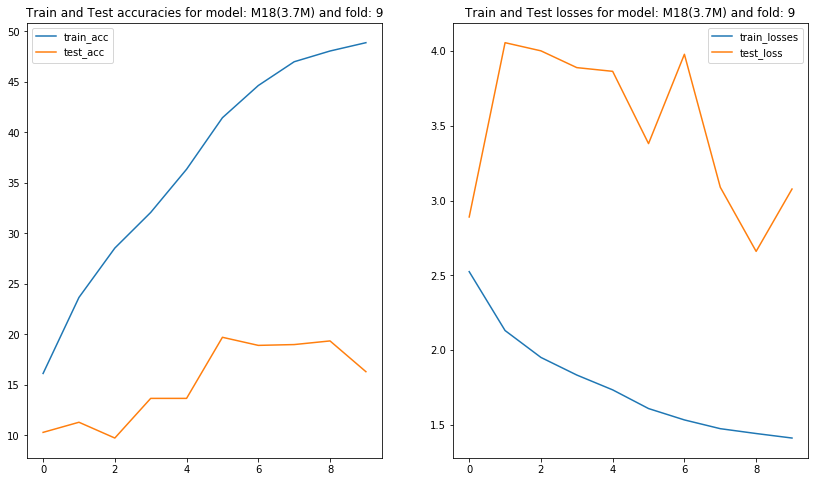

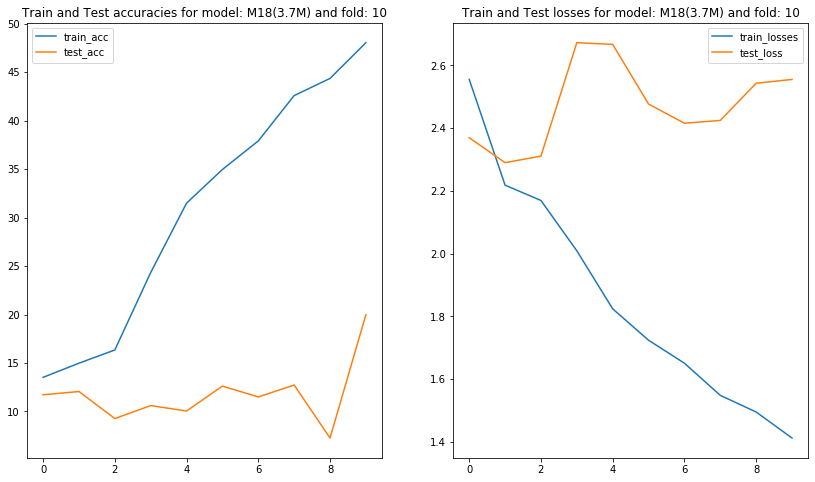

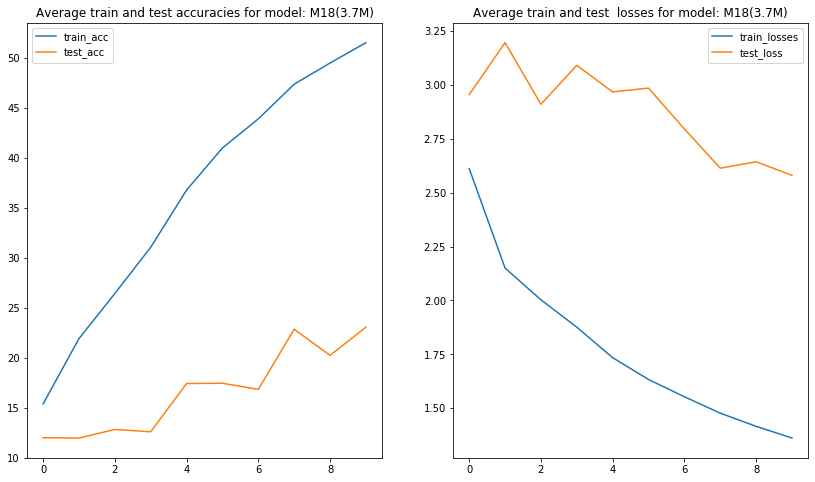

In [0]:
for i in range(1, 11):
  display(Image("/content/drive/My Drive/AudioClassifier/M18/fold{}.png".format(i)))
display(Image("/content/drive/My Drive/AudioClassifier/M18/avg.png"))

In [0]:
train_all_folds(M34Res, "M34-res(4M)")

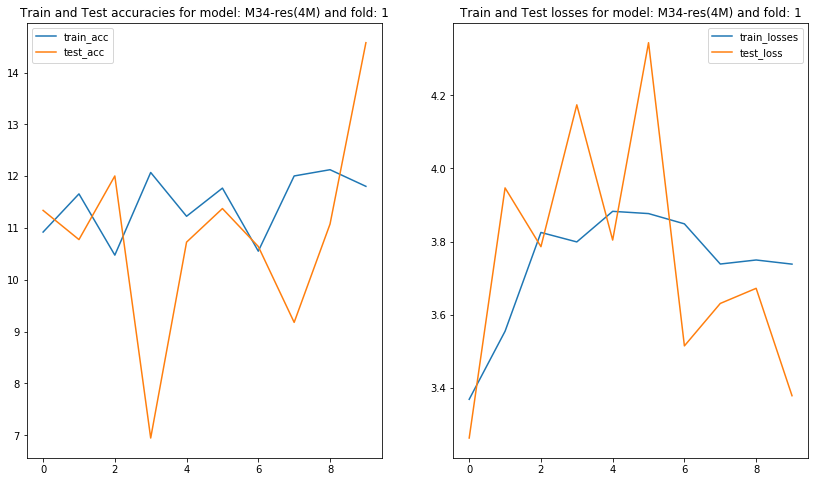

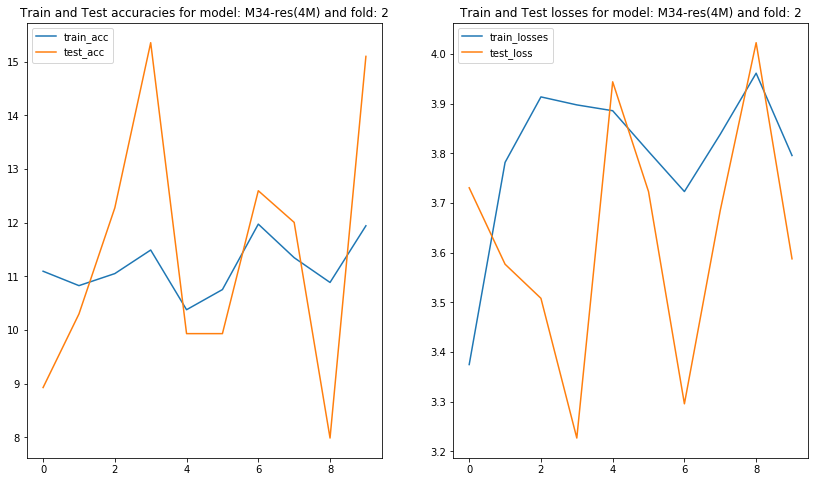

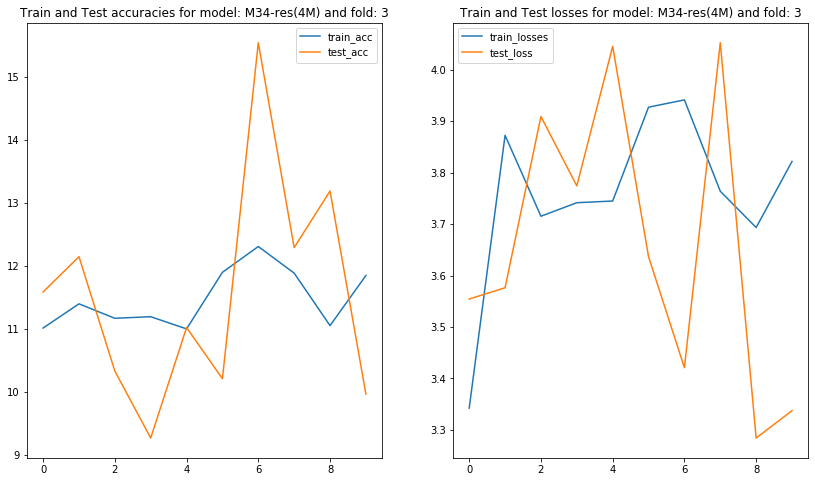

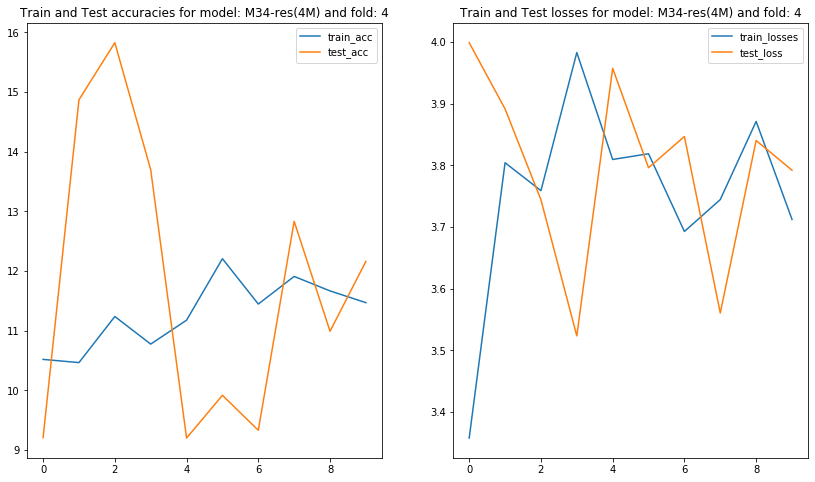

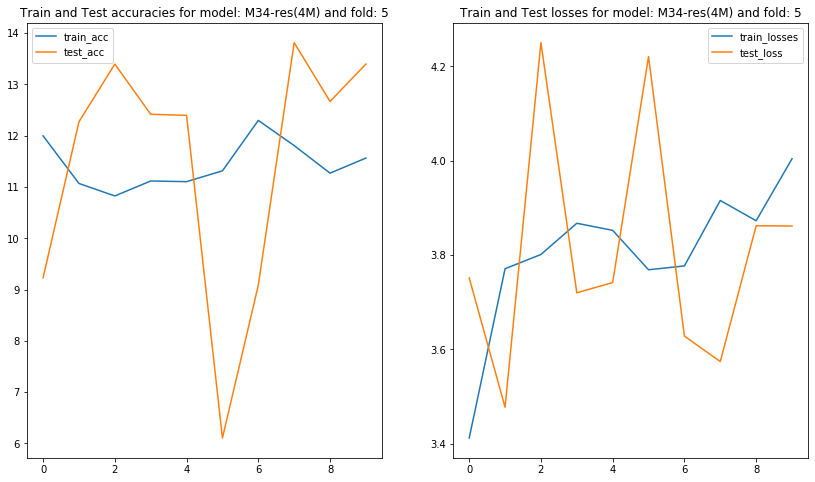

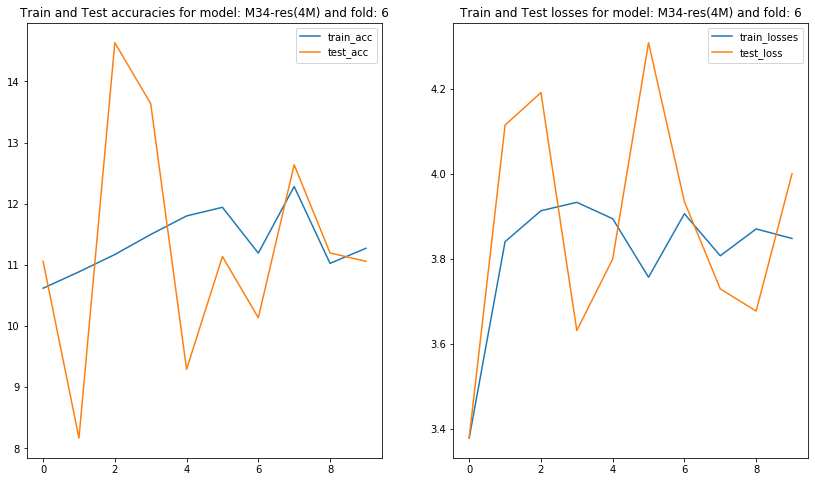

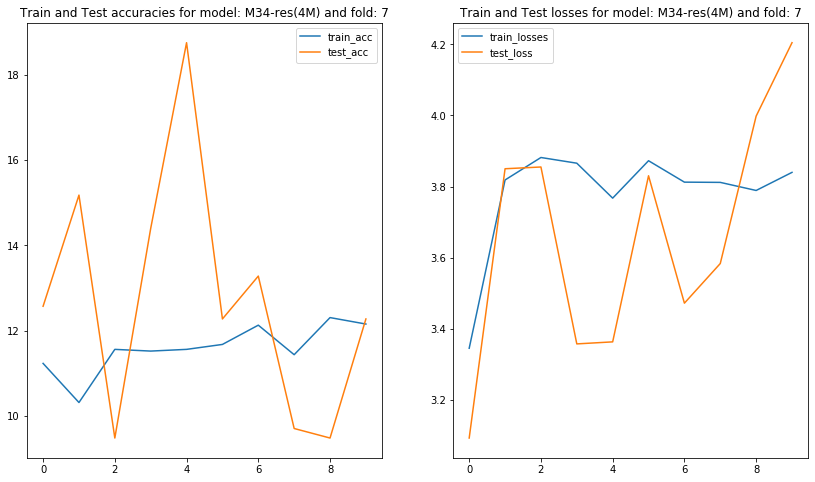

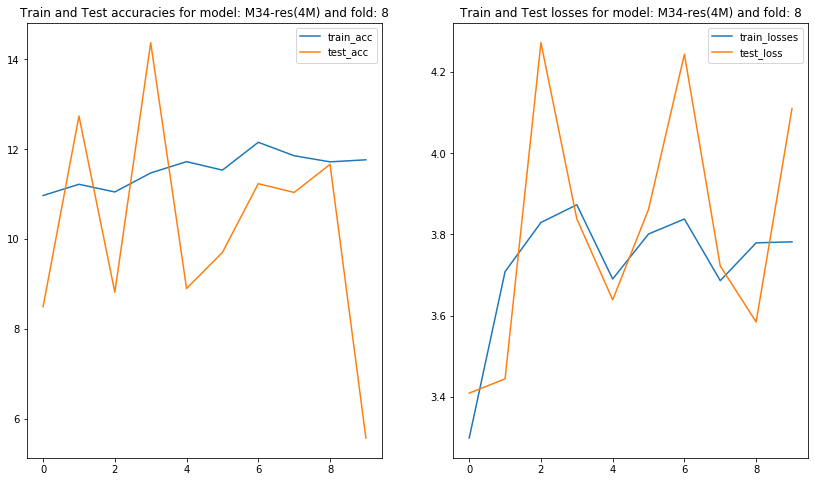

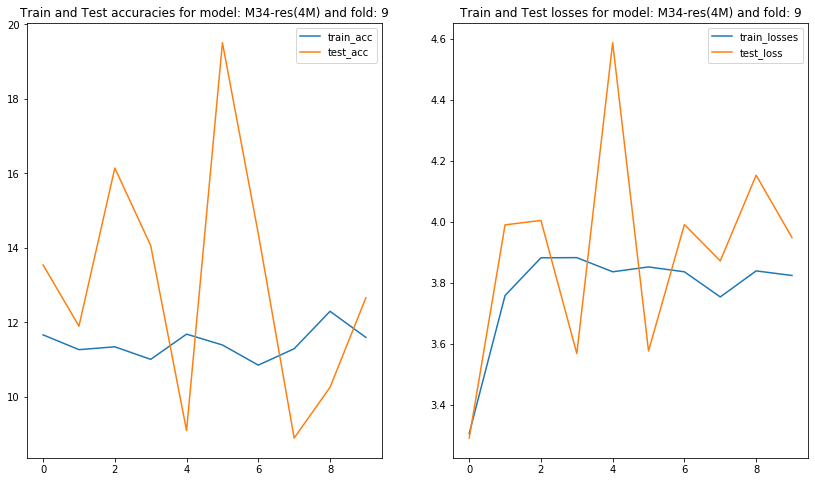

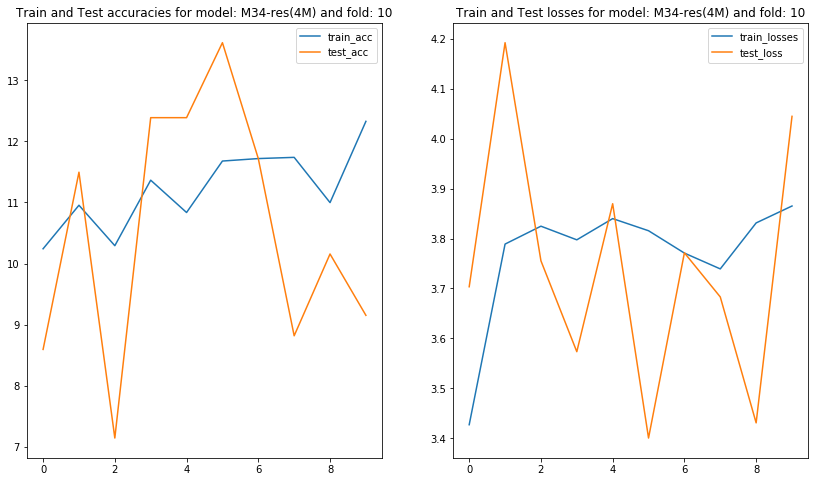

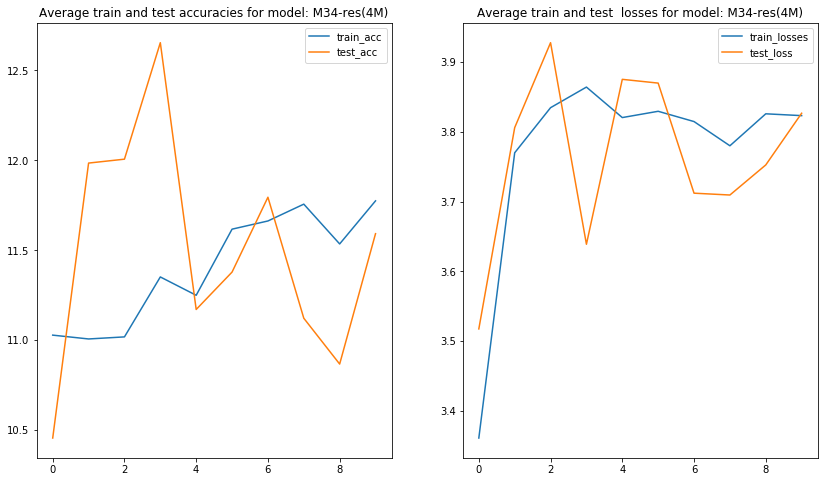

In [0]:
for i in range(1, 11):
  display(Image("/content/drive/My Drive/AudioClassifier/M34/fold{}.png".format(i)))
display(Image("/content/drive/My Drive/AudioClassifier/M34/avg.png"))